# 2023-hceres: HAL Data processing (PHARE / CRI)

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import unidecode
import json
import re
from typing import Any, Dict, List, Callable, Optional, Union, Pattern
import textwrap
import logging
import time, datetime
import os
import difflib

In [2]:
logging.basicConfig(
    format='[%(asctime)s][%(levelname)-5s][%(funcName)s#%(lineno)s] %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    level=logging.INFO,
)
LOGGER = logging.getLogger(__name__)
LOGGER.info('Logger loaded')

[2023-02-22 20:41:48][INFO ][<module>#7] Logger loaded


# Definitions

## Constants

Define primary constants

* `LAB_STRUCT_ID` : The identifier in HAL of the CES (15080)
* `NON_ALPHA_NUMERIC_REGEX` : Regex to cleanup all non alpha numeric characters
* `JSON_FILENAME` : Extration from HAL API.
* `CURRENT_TIMESTAMP`: The current timestamp of the last run of this notebook (used to retrieve some refenrentials)


In [3]:
# PHARE: 542292
#LAB_STRUCT_ID = 542292
# CRI: 
LAB_STRUCT_ID = 74131
NON_ALPHA_NUMERIC_REGEX = re.compile('[^a-z0-9_-]', re.IGNORECASE)
JSON_FILENAME = './result.cri.2023-02-21T20-11.json'
CURRENT_TIMESTAMP = datetime.datetime.now().timestamp()

## Functions

In [4]:
# As an alternative, we might extends pandas the official way
# See: https://pandas.pydata.org/docs/development/extending.html#extending-pandas

class DfOps(pd.core.frame.DataFrame):
    
    def __init__(
        self,
        dataframe: pd.core.frame.DataFrame,
        prefix: Optional[str] = None
    ) -> None:
        super().__init__(dataframe)
        self._prefix = (prefix or '').strip('_ ')
    
    def _display(self, df: pd.core.frame.DataFrame) -> 'DfOps':
        import IPython.display as display
        display.display(df)
        return self

    def display(self) -> 'DfOps':
        return self._display(self)
    
    def display_head(self, n=5) -> 'DfOps':
        return self._display(self.head(n=n))
    
    def _target_file(self, filename:str, ext: str) -> str:
        target_file = f'{self._prefix}_{filename}'.strip('_ ')
        target_file = re.compile('[^a-z0-9\.-]+', re.IGNORECASE).sub('_', target_file)
        target_file = re.compile(f'\.{ext}$', re.IGNORECASE).sub('', target_file)
        target_file = f'./exports/{target_file}.{ext.lower()}'
        return target_file
        
    def csv(self, filename: str, index=True, **kwargs) -> 'DfOps':
        target_file = self._target_file(filename=filename, ext='csv')
        to_csv_params = { 'index': index, **kwargs }
        LOGGER.info("Export to CSV file: %s (params: %s) (number of rows: %d)", target_file, to_csv_params, len(self))
        self.to_csv(target_file, **to_csv_params)
        return self
    
    def count(self, subset: List[str], column: str, dropna: bool = False) -> 'DfOps':
        return DfOps(self.value_counts(subset=subset, dropna=dropna).to_frame(name=column).reset_index())
    
    def barh(
        self,
        x: str,
        y: str,
        title: str,
        sort_by: List[str] = [],
        plot_params: Dict[str, Any] = None,
        title_params: Dict[str, Any] = None,
        sort_params: Dict[str, Any] = None,
    ) -> 'DfOps':
        sort_by = sort_by or [ y ]
        plot_params = plot_params or {}
        title_params = title_params or {}
        sort_params = sort_params or {}
        
        result_sort_params = {**dict(by=sort_by, ascending=True), **sort_params}
        LOGGER.debug('Sort current dataframe for graph "%s" => sort_params=%s', title, result_sort_params)
        sorted_df = self.sort_values(**result_sort_params)
        
        result_plot_params = {
            **dict(legend=False, xlabel='', ylabel='', figsize=(8, 4), rot=0, fontsize=12), # Default params
            **plot_params, # Override params
            **dict(kind='barh', title=title, x=x) # Forced params
        }
        
        LOGGER.debug('Create barh graph for "%s" => plot_params=%s)', title, result_plot_params)
        p = sorted_df.plot(**result_plot_params)
        
        default_title_params = dict(pad=20, fontdict={'fontsize': 16})
        result_title_params = {**default_title_params, **title_params}
        LOGGER.debug('Set title "%s" of current barh graph => title_params=%s', title, result_title_params)
        p.set_title(title, **result_title_params)
        plt.tight_layout()
        
        target_file = self._target_file(filename=title, ext='png').lower()
        LOGGER.info("Export barh graph to PNG file: %s", target_file)
        p.get_figure().savefig(target_file)
        plt.show()
        
        return DfOps(sorted_df)
    
    def pie(
        self,
        label_column: str,
        column: str,
        title: str,
        sort_by: List[str] = [],
        plot_params: Dict[str, Any] = None,
        title_params: Dict[str, Any] = None,
        sort_params: Dict[str, Any] = None,
    ) -> 'DfOps':
        sort_by = sort_by or [ column ]
        plot_params = plot_params or {}
        title_params = title_params or {}
        sort_params = sort_params or {}
        
        result_sort_params = {**dict(by=sort_by), **sort_params}
        LOGGER.debug('Sort current dataframe for graph "%s" => sort_params=%s', title, result_sort_params)
        sorted_df = self.sort_values(**result_sort_params)
        
        result_plot_params = {
            **dict(
                subplots=True,
                sharex=False,
                sharey=False,
                labels=sorted_df[label_column],
                figsize=(12, 12),
                autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * self[column].sum() / 100)),
                pctdistance=0.8,
                legend=False,
            ),
            **plot_params,
            **dict(kind='pie', subplots=True, y=column)
        }
        LOGGER.debug('Create pie graph for "%s" => plot_params=%s)', title, result_plot_params)
        axs = sorted_df.plot(**result_plot_params)
        plt.tight_layout()
        axs[0].set_ylabel('')
        
        default_title_params = dict(y=1.0, pad=-14, fontdict={'fontsize': 16})
        result_title_params = {**default_title_params, **title_params}
        LOGGER.debug('Set title "%s" of current pie graph => title_params=%s', title, result_title_params)
        axs[0].set_title(title, **result_title_params)
        
        target_file = self._target_file(f'{title}.png', 'png').lower() 
        LOGGER.info("Export pie graph to PNG file: %s", target_file)
        plt.figure(1).savefig(target_file)
        plt.show() 
        return DfOps(sorted_df)

    def group_min_values(
        self,
        label_column: str,
        value_column: str = 'count',
        min_value: Union[float, int] = 0,
        min_label: Callable[[List[Any]], str] = lambda l: f'Others ({len(l)})',
        export_title: Optional[str] = None,
    ) -> 'DfOps':
        
        # Retrieve small dataframe to create a new 'others' row
        dataframe_others = self[(self[value_column] <= min_value)]
        dataframe_others_labels = dataframe_others[label_column].to_list()
        dateframe_others_sum = dataframe_others[value_column].sum()
        dataframe_others = pd.DataFrame(
            dict([
                (label_column, min_label(dataframe_others_labels)),
                (value_column, dateframe_others_sum)
            ]),
            index=[0]
        )
        LOGGER.info(
            'Create a new dataframe for other values (others=(col[\'%s\'] < %s]) => %d rows aggreated',
            value_column, str(min_value), len(dataframe_others_labels)
        )
        if export_title:
            DfOps(dataframe_others, prefix=f'{export_title}_grouped_{value_column}').csv(filename='others.csv', index=False) 
        
        # From base dataframe, retrieve the top values
        dataframe_top = self[(self[value_column] > min_value)]
        if export_title:
            DfOps(dataframe_top, prefix=f'{export_title}_grouped_{value_column}').csv(filename='top.csv', index=False) 
            
        # Concat the 2 DfOps
        dataframe_result = pd.concat([dataframe_top, dataframe_others], ignore_index=True)
        dataframe_result = DfOps(dataframe_result.sort_values(by=[value_column], ascending=False), prefix=f'{export_title or ""}_grouped_{value_column}')
        LOGGER.info('New dataframe size: %d (Original dataframe size: %d)', len(dataframe_result), len(self))
        if export_title:
            dataframe_result.csv(filename='all.csv', index=False) 
            
        return DfOps(dataframe_result)

#  Datasets

This dataset has been saved by another notebook : `extract-data-to-json.ipynb`

Here, we just load the data. For more information, see [./extract-data-to-json.ipynb](./extract-data-to-json.ipynb) another


## HAL APIs

### Load HAL API results

Load the HAP API results from filaneme named `JSON_FILENAME`

In [5]:
with open(JSON_FILENAME, 'r') as fp:
    data = json.load(fp)
df = pd.DataFrame.from_dict(data['response']['docs'])
df

,label_s,openAccess_bool,keyword_s,authLastName_s,authFirstName_s,authFullName_s,authIdFullName_fs,authIdHasPrimaryStructure_fs,authIdHasStructure_fs,authIdHal_i,...,files_s,peerReviewing_s,audience_s,journalTitle_s,authStructId_i,journalIssn_s,anrProjectTitle_s,anrProjectAcronym_s,anrProjectReference_s,funding_s
0,"Amina Souag, Raúl Mazo, Camille Salinesi, Isab...",True,"[Security, Requirements engineering, Domain, O...","[Souag, Mazo, Salinesi, Comyn-Wattiau]","[Amina, Raúl, Camille, Isabelle]","[Amina Souag, Raúl Mazo, Camille Salinesi, Isa...","[0_FacetSep_Amina Souag, 752533_FacetSep_Raúl ...",[642134-0_FacetSep_Amina Souag_JoinSep_74131_F...,[642134-0_FacetSep_Amina Souag_JoinSep_74131_F...,"[752533, 10585, 182469]",...,[https://hal.science/hal-01584857/file/AMANDA-...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Houssem Chemingui, Camille Salinesi, Inès Gam ...",True,NaN,"[Chemingui, Salinesi, Gam El Golli, Mazo, Beng...","[Houssem, Camille, Inès, Raul, Henda]","[Houssem Chemingui, Camille Salinesi, Inès Gam...","[1054792_FacetSep_Houssem Chemingui, 10585_Fac...",[1657585-1054792_FacetSep_Houssem Chemingui_Jo...,[1657585-1054792_FacetSep_Houssem Chemingui_Jo...,"[1054792, 10585, 752533, 175192]",...,[https://hal.science/hal-02295947/file/Houssem...,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Houssem Chemingui, Ines Gam, Raul Mazo, Camill...",True,"[Product line engineering, Configuration proce...","[Chemingui, Gam, Mazo, Salinesi, Ghézala]","[Houssem, Ines, Raul, Camille, Henda]","[Houssem Chemingui, Ines Gam, Raul Mazo, Camil...","[0_FacetSep_Houssem Chemingui, 0_FacetSep_Ines...",[1657585-0_FacetSep_Houssem Chemingui_JoinSep_...,[1657585-0_FacetSep_Houssem Chemingui_JoinSep_...,"[752533, 10585, 175192]",...,[https://hal.science/hal-02295969/file/ConfiLo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Asmaa Achtaich, Raul Mazo, Nissrine Souissi, C...",True,NaN,"[Achtaich, Mazo, Souissi, Salinesi, Roudies]","[Asmaa, Raul, Nissrine, Camille, Ounsa]","[Asmaa Achtaich, Raul Mazo, Nissrine Souissi, ...","[177631_FacetSep_Asmaa Achtaich, 752533_FacetS...",[35427-177631_FacetSep_Asmaa Achtaich_JoinSep_...,[35427-177631_FacetSep_Asmaa Achtaich_JoinSep_...,"[177631, 752533, 14055, 10585, 177632]",...,NaN,1,2,International Journal of Engineering and Advan...,NaN,NaN,NaN,NaN,NaN,NaN
4,"Claudia Negri-Ribalta, Nicolas Herbaut, Camill...",True,"[Contact tracing, Trust, Data protection, Requ...","[Negri-Ribalta, Herbaut, Salinesi]","[Claudia, Nicolas, Camille]","[Claudia Negri-Ribalta, Nicolas Herbaut, Camil...","[0_FacetSep_Claudia Negri-Ribalta, 11908_Facet...",[2593700-0_FacetSep_Claudia Negri-Ribalta_Join...,[2593700-0_FacetSep_Claudia Negri-Ribalta_Join...,"[11908, 10585]",...,[https://hal.science/hal-03789989/file/CaiSe_n...,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,"Samira Si-Said Cherfi, Anna Perini, Selmin Nur...",True,NaN,"[Si-Said Cherfi, Perini, Nurcan]","[Samira, Anna, Selmin]","[Samira Si-Said Cherfi, Anna Perini, Selmin Nu...","[181035_FacetSep_Samira Si-Said Cherfi, 807934...",[24779-181035_FacetSep_Samira Si-Said Cherfi_J...,[24779-181035_FacetSep_Samira Si-Said Cherfi_J...,"[181035, 807934, 1006831]",...,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166,"Boubakr Nour, Adlen Ksentini, Nicolas Herbaut,...",True,NaN,"[Nour, Ksentini, Herbaut, Frangoudis, Moungla]","[Boubakr, Adlen, Nicolas, Pantelis, Hassine]","[Boubakr Nour, Adlen Ksentini, Nicolas Herbaut...","[174302_FacetSep_Boubakr Nour, 839126_FacetSep...",[43706-174302_FacetSep_Boubakr Nour_JoinSep_74...,[43706-174302_FacetSep_Boubakr Nour_JoinSep_74...,"[174302, 839126, 11908]",...,NaN,1,2,IEEE Networking Letters,[7550],2576-3156,NaN,NaN,NaN,NaN
167,"Elena Kornyshova, Rebecca Deneckere, Kaoutar S...",True,NaN,"[Kornyshova, Deneckere, Sadouki, Gressier-Soud...","[Elena, Rebecca, Kaoutar, Eric, Sjaak]","[Elena Kornyshova, Rebecca Deneckere, Kaoutar ...","[182267_FacetSep_Elena Kornyshova, 864299_Face...",[153

### Stats

View some minor stats on non nan row for each columns

In [6]:
# List all non nan row for each columns
DfOps(df.count().to_frame()).csv('rows-having-values.csv', index=True)

[2023-02-22 20:41:48][INFO ][csv#35] Export to CSV file: ./exports/rows-having-values.csv (params: {'index': True}) (number of rows: 27)


,0
label_s,170
openAccess_bool,170
keyword_s,84
authLastName_s,170
authFirstName_s,170
authFullName_s,170
authIdFullName_fs,170
authIdHasPrimaryStructure_fs,170
authIdHasStructure_fs,170
authIdHal_i,165


## Authors Datasets

In this section, we will work on the authors to find all name forms.

This came from HAL Extractions.


### All authors (from HAL)...


In [7]:
# Cleanup useles columns for authors and explode on same list length
authors = df[['authLastName_s', 'authFirstName_s', 'authFullName_s']]
authors = authors.explode(['authLastName_s', 'authFirstName_s', 'authFullName_s'])
authors = authors.drop_duplicates(ignore_index=True)
DfOps(authors).csv('authors-all.csv', index=False)

[2023-02-22 20:41:48][INFO ][csv#35] Export to CSV file: ./exports/authors-all.csv (params: {'index': False}) (number of rows: 278)


,authLastName_s,authFirstName_s,authFullName_s
0,Souag,Amina,Amina Souag
1,Mazo,Raúl,Raúl Mazo
2,Salinesi,Camille,Camille Salinesi
3,Comyn-Wattiau,Isabelle,Isabelle Comyn-Wattiau
4,Chemingui,Houssem,Houssem Chemingui
...,...,...,...
273,Moungla,Hassine,Hassine Moungla
274,Sadouki,Kaoutar,Kaoutar Sadouki
275,Epure,Elena Viorica,Elena Viorica Epure
276,Martins,Joao,Joao Martins


### Current structure (from HAL)


As an author may have multiple structures, the number of items in `auth*` columns will not be the same !

We will have the same length in the following list :

* `authId_i`, `authLastName_s`, `authFirstName_s`, `authFullName_s`
* `authStructId_i`, `authIdHasPrimaryStructure_fs`

But the length of list `authId_i` and `authStructId_i` may be different.

We will use the facet `authIdHasPrimaryStructure_fs` to correlate an author with its `authStructId_i`.

At the end, we will produces 2 DataFrames:
* `struct_authors`: contains all the authors of the current structure
* `similarity_struct_authors`: contains all authors similarity

In [8]:
def fs_struct_authors(dataframe: pd.core.frame.DataFrame, column: str, pattern: Pattern) -> pd.core.frame.DataFrame:
    # Select only column of interest
    ndf = dataframe[['authFullName_s', 'authFirstName_s', 'authLastName_s', column]]
    ndf = ndf.explode(['authLastName_s', 'authFirstName_s', 'authFullName_s']).explode([column]).drop_duplicates(ignore_index=True)
    ndf[[f'{column}_fullName', f'{column}_structId']] = ndf[column].str.extract(pattern)
    ndf = ndf.astype({f'{column}_structId': 'int'})
    # Correlate with authFullName_s
    ndf = ndf[ndf[f'{column}_fullName'] == ndf['authFullName_s']]
    # And structure id
    ndf = ndf[ndf[f'{column}_structId'] == LAB_STRUCT_ID]
    ndf = ndf.drop(columns=[column, f'{column}_fullName', f'{column}_structId']).drop_duplicates(ignore_index=True)
    return DfOps(ndf).csv(filename=f'authors-struct-{LAB_STRUCT_ID}-{column}.csv', index=False)

In [9]:
fs_auth_id_has_structure_authors = fs_struct_authors(
    dataframe=df,
    column='authIdHasStructure_fs',
    pattern=r'^.*_FacetSep_(?P<fullName>.*)_JoinSep_(?P<structId>\d+)_FacetSep_.*$'
)
fs_auth_id_has_primary_structure_authors = fs_struct_authors(
    dataframe=df,
    column='authIdHasPrimaryStructure_fs',
    pattern=r'^.*_FacetSep_(?P<fullName>.*)_JoinSep_(?P<structId>\d+)_FacetSep_.*$'
)
struct_authors = pd.concat([fs_auth_id_has_structure_authors, fs_auth_id_has_primary_structure_authors]) \
    .drop_duplicates(ignore_index=True) \
    .sort_values(by=['authLastName_s', 'authFirstName_s', 'authFullName_s']) \
    .reset_index(drop=True)
struct_authors = DfOps(struct_authors).csv(f'authors-struct-{LAB_STRUCT_ID}.csv', index=False)
struct_authors

[2023-02-22 20:41:48][INFO ][csv#35] Export to CSV file: ./exports/authors-struct-74131-authIdHasStructure_fs.csv (params: {'index': False}) (number of rows: 80)
[2023-02-22 20:41:48][INFO ][csv#35] Export to CSV file: ./exports/authors-struct-74131-authIdHasPrimaryStructure_fs.csv (params: {'index': False}) (number of rows: 80)
[2023-02-22 20:41:48][INFO ][csv#35] Export to CSV file: ./exports/authors-struct-74131.csv (params: {'index': False}) (number of rows: 80)


,authFullName_s,authFirstName_s,authLastName_s
0,Salvador Abreu,Salvador,Abreu
1,Asmaa Achtaich,Asmaa,Achtaich
2,Ziad Al Nabhani,Ziad,Al Nabhani
3,Amal Alsayed,Amal,Alsayed
4,Afef Awadid,Afef,Awadid
...,...,...,...
75,Mohammed El Amin Tebib,Mohammed El Amin,Tebib
76,Nino Tskhovrebashvili,Nino,Tskhovrebashvili
77,Angela Villota,Angela,Villota
78,Angela Villota Gomez,Angela,Villota Gomez


### Author names similarities (in HAL)

In [10]:
# will be better with faster with levenstein distance.
# Anyway, we will use what's in python builtin modules...
similarity_struct_authors = struct_authors.merge(struct_authors, how="cross", suffixes=('', '_alt')) # This will make a very big DataFrame !!
similarity_struct_authors = similarity_struct_authors[
    (similarity_struct_authors.authFullName_s != similarity_struct_authors.authFullName_s_alt)
    | (similarity_struct_authors.authLastName_s != similarity_struct_authors.authLastName_s_alt)
    | (similarity_struct_authors.authFirstName_s != similarity_struct_authors.authFirstName_s_alt)
]
similarity_struct_authors['similarity'] = similarity_struct_authors.apply(
    lambda r: difflib.SequenceMatcher(None, r['authFullName_s'], r['authFullName_s_alt']).ratio(), 
    axis=1
)
similarity_struct_authors = similarity_struct_authors.reset_index(drop=True)
DfOps(similarity_struct_authors[similarity_struct_authors.similarity > 0.8]).csv(f'authors-struct-{LAB_STRUCT_ID}-similarity-over-0.8.csv')

[2023-02-22 20:41:48][INFO ][csv#35] Export to CSV file: ./exports/authors-struct-74131-similarity-over-0.8.csv (params: {'index': True}) (number of rows: 58)


,authFullName_s,authFirstName_s,authLastName_s,authFullName_s_alt,authFirstName_s_alt,authLastName_s_alt,similarity
692,Nourhène Ben Rabah,Nourhène,Ben Rabah,Nourhène Ben Rabah,Nourhène,Rabah,1.000000
720,Ines Ben Tekaya,Ines,Ben Tekaya,Ines Ben Tekeya,Ines,Ben Tekeya,0.933333
799,Ines Ben Tekeya,Ines,Ben Tekeya,Ines Ben Tekaya,Ines,Ben Tekaya,0.933333
1280,Rebecca Deneckere,Rebecca,Deneckere,Rébecca Deneckère,Rébecca,Deneckère,0.882353
1281,Rebecca Deneckere,Rebecca,Deneckere,Rébecca Deneckére,Rébecca,Deneckére,0.882353
1285,Rebecca Deneckere,Rebecca,Deneckere,Rébecca Déneckère,Rébecca,Déneckère,0.823529
1359,Rébecca Deneckère,Rébecca,Deneckère,Rebecca Deneckere,Rebecca,Deneckere,0.882353
1360,Rébecca Deneckère,Rébecca,Deneckère,Rébecca Deneckére,Rébecca,Deneckére,0.941176
1364,Rébecca Deneckère,Rébecca,Deneckère,Rébecca Déneckère,Rébecca,Déneckère,0.941176
1438,Rébecca Deneckére,Rébecca,Deneckére,Rebecca Deneckere,Rebecca,Deneckere,0.882353


## Rerefentials Datasets

In [11]:
# datetime.timedelta(days=1).total_seconds() = 86400
def download_referential(target_file: str, ref_url: str, delta: int = 86400):
    mtime = 0
    if os.path.exists(target_file):
        mtime = os.path.getmtime(target_file)

    LOGGER.info('%s modification time %d (current timestamp: %d)', target_file, mtime, CURRENT_TIMESTAMP)

    if CURRENT_TIMESTAMP - mtime > delta:
        LOGGER.info('Download %s referential at %s', target_file, ref_url)
        resp = requests.get(ref_url);
        resp.status_code
        if resp.status_code == 200:
            with open(target_file, 'wb') as fd:
                fd.write(resp.content)
            LOGGER.info('URL Content %s has been saved to file: %s', ref_url, target_file)
        else:
            LOGGER.error('Cannot retrieve file %s. Status Code: %d', target_file, resp.status_code)
    else:
        LOGGER.info('Skipping download of file %s as it has been modified %d seconds ago', target_file, max(0, CURRENT_TIMESTAMP - mtime))

### Econlit

EconLit referential is available at https://www.aeaweb.org/econlit/journal_list.php .

#### HTML Parsing

A JSON Datasets can be extract from a web browser (such as Chrome or Firefox) using the simple following commands in a web console:

```javascript
$$('.journaldesc')
  .map(item => $(item).text().split('\n'))
  .map(arr => Object.assign(
    { Title: arr[0].trim() },
    Object.fromEntries(
      arr
      .slice(1)
      .map(val => val.trim())
      .map(line => [
        line.split(':', 1).join().trim(),
        line.split(':').slice(1).join(':').trim()
      ]))
  ));
```

This will extract all the required code in a object that can be copy/paste into a JSON file

**Note 1 :** It's possible to have some ISSN duplicated here. For example, `0013-0117` have several titles (_Economic History Review_ or _Economic History Review, Second Series_)

**Note 2 :** For formating purpose, `$$` should be replace with a single `$`

#### CSV Export

For a long time, it wasn't possible to retrieve an export of the Econlit referential. So, we did it using a simple javasript export ! Even if it was working pretty well, Econlit evolved and now we have a real CSV export of the Econlit referential.

In [12]:
download_referential(target_file='./ref.econlit.csv', ref_url='https://www.aeaweb.org/journals/econlit-journals/export')

[2023-02-22 20:41:48][INFO ][download_referential#7] ./ref.econlit.csv modification time 1677010416 (current timestamp: 1677098508)
[2023-02-22 20:41:48][INFO ][download_referential#10] Download ./ref.econlit.csv referential at https://www.aeaweb.org/journals/econlit-journals/export
[2023-02-22 20:41:49][INFO ][download_referential#16] URL Content https://www.aeaweb.org/journals/econlit-journals/export has been saved to file: ./ref.econlit.csv


In [13]:
econlit_df = pd.read_csv('./ref.econlit.csv').drop(columns=['EconLit Coverage', 'Formerly', 'See']).rename(columns={'Name': 'Title'})
LOGGER.info('Econlit original size : %d', econlit_df["Title"].size)
# Cleaning data
#econlit_df['ISSN'] = econlit_df['ISSN'].transform(lambda x: x.strip())
econlit_df = econlit_df.drop_duplicates(subset=['ISSN'], ignore_index=True)
LOGGER.info('Econlit size after droping duplicates : %d', econlit_df["Title"].size)
econlit_df

[2023-02-22 20:41:49][INFO ][<module>#2] Econlit original size : 2036
[2023-02-22 20:41:49][INFO ][<module>#6] Econlit size after droping duplicates : 1908


,Title,URL,ISSN
0,4OR: A Quarterly Journal of Operations Research,https://link.springer.com/journal/volumesAndIs...,1619-4500
1,Academia Economic Papers,https://www.econ.sinica.edu.tw/posts/137,1018-161X
2,"Accounting, Business and Financial History",NaN,0958-5206
3,"Accounting, Economics, and Law: A Convivium",http://www.degruyter.com/view/j/ael,2194-6051
4,Accounting History Review,http://www.tandfonline.com/loi/rabf21,2155-2851
...,...,...,...
1903,Zeitschrift für Wirtschafts- und Sozialwissens...,NaN,0342-1783
1904,Zeitschrift für Wirtschafts- und Unternehmense...,NaN,1439-880X
1905,Zeitschrift für Wirtschaftspolitik,https://www.degruyter.com/journal/key/zfwp/html,0721-3808
1906,Zhournal Novoi Ekonomicheskoi Associacii/Journ...,http://www.econorus.org/enjarchive.phtml,2221-2264


### MathSciNet

MathSciNet referential is available at https://mathscinet.ams.org/mathscinet/mrcit/journal_list.html


#### HTML Parsing

A JSON Datasets can be extract from browser using the simple following commands in a web console:

```javascript
$$('table tr')
  .map(i => $(i).find('td'))
  .filter(a => a.length === 4)
  .map(a => ({
    ISSN: $(a[0]).text().trim(),
    Title: $(a[1]).text().trim(),
    Publisher: $(a[2]).text().trim(),
    Start_Year: $(a[3]).text().trim()
  }))
```

**Note 1:** We may have duplicates in `ISSN` columns

In [14]:
mathscinet_df = pd.read_json('./ref.mathscinet.json').drop(columns=['Publisher', 'Start_Year'])
print(f'MathSciNet original size : {mathscinet_df["Title"].size}')
mathscinet_df['ISSN'] = mathscinet_df['ISSN'].transform(lambda x: x.strip())
mathscinet_df = mathscinet_df.drop_duplicates(subset=['ISSN'], ignore_index=True)
print(f'MathSciNet size after cleaning duplicates : {mathscinet_df["Title"].size}')
mathscinet_df

MathSciNet original size : 765
MathSciNet size after cleaning duplicates : 617


,ISSN,Title
0,0271-4132,Contemp. Math.
1,0302-9743,Lecture Notes in Comput. Sci.
2,0160-7634,Proc. Sympos. Appl. Math.
3,0082-0717,Proc. Sympos. Pure Math.
4,0025-5858,Abh. Math. Semin. Univ. Hambg.
...,...,...
612,0165-2125,Wave Motion
613,0044-2267,ZAMM Z. Angew. Math. Mech.
614,0232-2064,Z. Anal. Anwend.
615,0044-2275,Z. Angew. Math. Phys.


### Scimago JCR

A CSV is already available on the [scimago website](https://www.scimagojr.com/journalrank.php) and can be donwload with the following links: https://www.scimagojr.com/journalrank.php?out=xls


**Note :** The `Issn` columns may contains multiples ISSN 

In [15]:
download_referential(target_file='./ref.scimagojr_2021.csv', ref_url='https://www.scimagojr.com/journalrank.php?out=xls')

[2023-02-22 20:41:49][INFO ][download_referential#7] ./ref.scimagojr_2021.csv modification time 1677010419 (current timestamp: 1677098508)
[2023-02-22 20:41:49][INFO ][download_referential#10] Download ./ref.scimagojr_2021.csv referential at https://www.scimagojr.com/journalrank.php?out=xls
[2023-02-22 20:41:52][INFO ][download_referential#16] URL Content https://www.scimagojr.com/journalrank.php?out=xls has been saved to file: ./ref.scimagojr_2021.csv


In [16]:
scimagojr_df = pd.read_csv('./ref.scimagojr_2021.csv', sep=';')[['Title', 'Issn', 'Categories', 'SJR Best Quartile']]
scimagojr_df = scimagojr_df.rename(columns={'Issn': 'ISSNs', 'SJR Best Quartile': 'SJR_BEST_QUARTILE', 'Categories': 'CATEGORIES'})
LOGGER.info('Scimago original size: %d', scimagojr_df["Title"].size)

scimagojr_df['ISSN'] = scimagojr_df['ISSNs'].apply(lambda x: x.split(','))
scimagojr_df = scimagojr_df.explode('ISSN')
LOGGER.info('Scimago size after exploding "ISSNs" columns: %d', scimagojr_df["Title"].size)

scimagojr_df['ISSN'] = scimagojr_df['ISSN'].transform(lambda x: '-'.join(textwrap.wrap(x.strip(),4)))
scimagojr_df = scimagojr_df.drop(columns=['ISSNs']).drop_duplicates(subset=['ISSN'], ignore_index=True)
LOGGER.info('Scimago size after exploding "ISSNs" and droping duplicates: %d', scimagojr_df["Title"].size)

scimagojr_df

[2023-02-22 20:41:52][INFO ][<module>#3] Scimago original size: 27339
[2023-02-22 20:41:52][INFO ][<module>#7] Scimago size after exploding "ISSNs" columns: 43410
[2023-02-22 20:41:53][INFO ][<module>#11] Scimago size after exploding "ISSNs" and droping duplicates: 43369


,Title,CATEGORIES,SJR_BEST_QUARTILE,ISSN
0,Ca-A Cancer Journal for Clinicians,Hematology (Q1); Oncology (Q1),Q1,1542-4863
1,Ca-A Cancer Journal for Clinicians,Hematology (Q1); Oncology (Q1),Q1,0007-9235
2,Nature Reviews Molecular Cell Biology,Cell Biology (Q1); Molecular Biology (Q1),Q1,1471-0072
3,Nature Reviews Molecular Cell Biology,Cell Biology (Q1); Molecular Biology (Q1),Q1,1471-0080
4,Quarterly Journal of Economics,Economics and Econometrics (Q1),Q1,0033-5533
...,...,...,...,...
43364,WSEAS Transactions on Information Science and ...,Computer Science Applications; Information Sys...,-,1790-0832
43365,WSEAS Transactions on Systems,Computer Science Applications; Control and Sys...,-,1109-2777
43366,Z Badan nad Ksiazka i Ksiegozbiorami Historycz...,Arts and Humanities (miscellaneous); Communica...,-,2544-8730
43367,Z Badan nad Ksiazka i Ksiegozbiorami Historycz...,Arts and Humanities (miscellaneous); Communica...,-,1897-0788


### HCERES Vague B 2021


#### PDF Export

Arf, this is most painfull format (a old school PDF) ! This should be done (almost) manually...

The current file is available here:
https://www.hceres.fr/sites/default/files/media/downloads/hceres_2021_liste_domaine_shs1_economie_et_gestion.pdf

**Steps :**

* Extract a flat text of the PDF
* Remove useles data such as the presentation, the page numbers, ...
* Replace using regex :
  * Searched: `^(.{9})\s+(.*)\s+([^\s]+)\s+([^\s]+)\s+([^\s]+)\s?$`
  * Replacement: `{"ISSN":"$1", "Title": "$2", "CoNRS_2020": "$3"; "FNEGE_2019": "$4", "HCERES_2021": "$5" },`
* Remove the `,` char at the end of the document
* Append `[` char at the beginning and `]` at the end of the document

**Note :** We may have duplicates in `ISSN` columns

In [17]:
hceres_df = pd.read_json('./ref.hceres.json')
LOGGER.info('HCERES original size: %d', hceres_df["Title"].size)

hceres_df['ISSN'] = hceres_df['ISSN'].transform(lambda x: x.strip())
hceres_df = hceres_df.drop_duplicates(subset=['ISSN'], ignore_index=True)
hceres_df = hceres_df.replace('-', np.nan)
LOGGER.info('HCERES size after cleaning duplicates: %d', hceres_df["Title"].size)

hceres_df

[2023-02-22 20:41:53][INFO ][<module>#2] HCERES original size: 937
[2023-02-22 20:41:53][INFO ][<module>#7] HCERES size after cleaning duplicates: 924


,ISSN,Title,CoNRS_2020,FNEGE_2019,HCERES_2021
0,2034-9130,@GRH,NaN,3,B
1,1619-4500,4OR: A Quarterly Journal of Operations Research,3,NaN,B
2,0001-3072,Abacus,3,2,A
3,1941-6520,Academy of Management Annals,2,1,A
4,0001-4273,Academy of Management Journal,1,1,A
...,...,...,...,...,...
919,1011-4548,World Competition. Law and Economics Review,3,NaN,B
920,0305-750X,World Development,1,NaN,A
921,0378-5920,World Economy,2,NaN,A
922,1474-7456,World Trade Review,4,NaN,C


### CNRS Section 37 Juin 2020

In [18]:
cnrs_s37_df = pd.read_json('./ref.cnrs-s37-juin-2020.json')
cnrs_s37_df = cnrs_s37_df.rename(columns={'issn': 'ISSN', 'title': 'Title'})
LOGGER.info('CNRS Section 37 original size: %d', len(cnrs_s37_df))
cnrs_s37_df

[2023-02-22 20:41:53][INFO ][<module>#3] CNRS Section 37 original size: 843


,Title,ISSN,domaine,cat
0,4OR: A Quarterly Journal of Operations Research,1619-4500,RO,3
1,Abacus,0001-3072,CPT,3
2,Academy of Management Annals,1941-6520,GEN,2
3,Academy of Management Journal,0001-4273,GEN,1
4,Academy of Management Learning and Education,1537-260X,GEN,2
...,...,...,...,...
838,World Competition. Law and Economics Review,1011-4548,EcoDroit,3
839,World Development,0305-750X,DevTrans,1
840,World Economy,0378-5920,Macro,2
841,World Trade Review,1474-7456,Macro,4


# All documents types

## Document type distribution

[2023-02-22 20:41:53][INFO ][csv#35] Export to CSV file: ./exports/document_types.csv (params: {'index': False}) (number of rows: 11)
[2023-02-22 20:41:53][INFO ][barh#77] Export barh graph to PNG file: ./exports/distribution_by_types.png


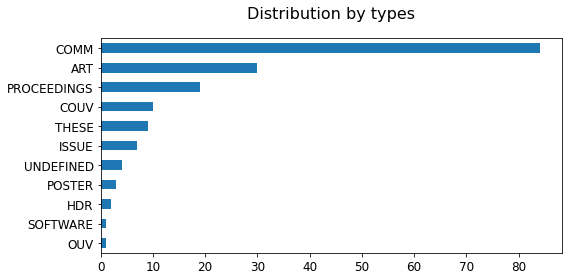

[2023-02-22 20:41:53][INFO ][<module>#5] Number of document without docType_s: 0
[2023-02-22 20:41:53][INFO ][<module>#6] Number of document types: 11


,docType_s,count
9,OUV,1
10,SOFTWARE,1
8,HDR,2
7,POSTER,3
6,UNDEFINED,4
5,ISSUE,7
4,THESE,9
3,COUV,10
2,PROCEEDINGS,19
1,ART,30


In [19]:
doc_types = DfOps(df) \
    .count(subset=['docType_s'], column='count') \
    .csv('document_types.csv', index=False) \
    .barh(title='Distribution by types', x='docType_s', y='count')
LOGGER.info('Number of document without docType_s: %d', doc_types[doc_types.docType_s.isnull()]["count"].sum())
LOGGER.info('Number of document types: %d', doc_types["docType_s"].dropna().size)
doc_types

In [20]:
doc_types_others = DfOps(doc_types).group_min_values(
    label_column = 'docType_s',
    value_column = 'count',
    min_value = 5,
    min_label = lambda l: f'{" + ".join(l)}'
)
doc_types_others

[2023-02-22 20:41:53][INFO ][group_min_values#152] Create a new dataframe for other values (others=(col['count'] < 5]) => 5 rows aggreated
[2023-02-22 20:41:53][INFO ][group_min_values#167] New dataframe size: 7 (Original dataframe size: 11)


,docType_s,count
5,COMM,84
4,ART,30
3,PROCEEDINGS,19
6,OUV + SOFTWARE + HDR + POSTER + UNDEFINED,11
2,COUV,10
1,THESE,9
0,ISSUE,7


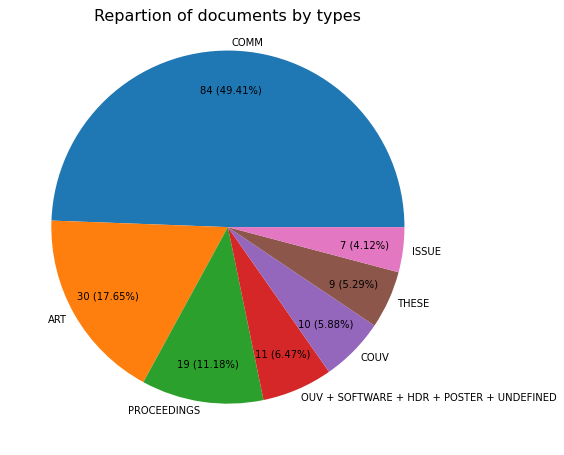

In [21]:
axs = doc_types_others['count'].plot(
    kind='pie',
    subplots=True,
    sharex=False,
    sharey=False,
    #title='Occurence',
    labels=doc_types_others['docType_s'],
    figsize=(8, 8),
    #autopct='%1.1f%%',
    autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * doc_types_others['count'].sum() / 100)),
    pctdistance=0.78,
    #rotatelabels=False,
    labeldistance=1.05
)
plt.tight_layout()
#plt.figure(1).savefig(occurence_png_target_file)
axs[0].set_ylabel('')
axs[0].set_title('Repartion of documents by types', y=1.0, pad=-14, fontdict={'fontsize': 16})
plt.figure(1).savefig(f'./exports/document_types_distribution_pie.png')
plt.show()

## Audiences

In [22]:
audience_values = {
    '1': 'NOT_SPECIFIED',
    '2': 'INTERNATIONAL',
    '3': 'NATIONAL',
}

audiences = df['audience_s'].apply(lambda x: audience_values.get(str(x or '1'), 'NOT_SPECIFIED')).to_frame()
audiences = audiences[['audience_s']].value_counts(dropna=False).to_frame(name='count').reset_index()
audiences

,audience_s,count
0,INTERNATIONAL,111
1,NOT_SPECIFIED,55
2,NATIONAL,4


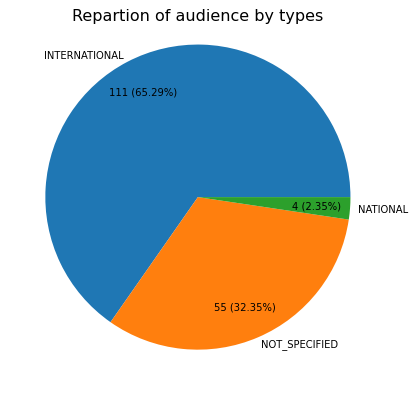

In [23]:
axs = audiences['count'].plot(
    kind='pie',
    subplots=True,
    sharex=False,
    sharey=False,
    #title='Occurence',
    labels=audiences['audience_s'],
    figsize=(6, 6),
    #autopct='%1.1f%%',
    autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * audiences['count'].sum() / 100)),
    pctdistance=0.78,
    #rotatelabels=False,
    labeldistance=1.05
)
plt.tight_layout()
#plt.figure(1).savefig(occurence_png_target_file)
axs[0].set_ylabel('')
axs[0].set_title('Repartion of audience by types', y=1.0, pad=-14, fontdict={'fontsize': 16})
plt.figure(1).savefig(f'./exports/audience_distribution_pie.png')
plt.show()

## Open Access

In [24]:
def open_access(dataframe,
                title: str,
                filename: str = None,
                params: Dict[str, Any] = dict()):
    
    filename = (filename or '').strip()
    prefix_filename = f'open_access_{filename}' if len(filename) > 0 else 'open_access'
    
    open_access_number_series = dataframe['openAccess_bool'].value_counts().reindex([True, False])
    open_access_number = open_access_number_series.to_frame(name='count').reset_index()
    DfOps(open_access_number).csv(filename=f'{prefix_filename}_distribution.csv', index=False)
    
    default_params = dict(
        kind='pie',
        subplots=True,
        sharex=False,
        sharey=False,
        #title=title,
        ylabel='',
        labels=open_access_number_series.index.tolist(),
        figsize=(6, 6),
        autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * open_access_number['count'].sum() / 100)),
        pctdistance=0.7,
        fontsize=14,
    )
    open_access_number_png_target_file = f'./exports/{prefix_filename}_distribution.png'
    axs = open_access_number_series.plot(**{**default_params, **params})
    plt.tight_layout()
    axs[0].set_ylabel('')
    axs[0].set_title(
        label = title,
        y = 1.0,
        pad = 6,
        fontdict = {'fontsize': 16},
    )
    plt.figure(1).savefig(open_access_number_png_target_file)
    plt.show()
    LOGGER.info('Saving figure to: "%s"', open_access_number_png_target_file)
    
    return open_access_number

[2023-02-22 20:41:53][INFO ][csv#35] Export to CSV file: ./exports/open_access_all_doc_type_distribution.csv (params: {'index': False}) (number of rows: 2)


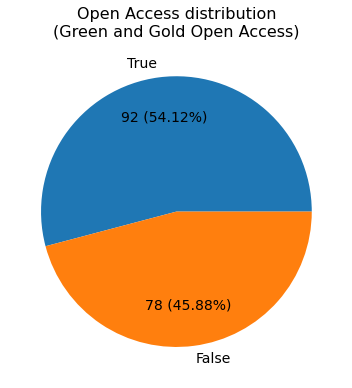

[2023-02-22 20:41:53][INFO ][open_access#38] Saving figure to: "./exports/open_access_all_doc_type_distribution.png"


,index,count
0,True,92
1,False,78


In [25]:
open_access(
    dataframe=df,
    filename='all_doc_type',
    title='Open Access distribution\n(Green and Gold Open Access)',
    params=dict(
        figsize=(5,5),
        pctdistance=0.70,
        labeldistance=1.1
    )
)

# Articles : Data Processing

In [26]:
df_art = df[df['docType_s'] == 'ART'].drop(columns=['docType_s']).reset_index(drop=True)
df_art

,label_s,openAccess_bool,keyword_s,authLastName_s,authFirstName_s,authFullName_s,authIdFullName_fs,authIdHasPrimaryStructure_fs,authIdHasStructure_fs,authIdHal_i,...,files_s,peerReviewing_s,audience_s,journalTitle_s,authStructId_i,journalIssn_s,anrProjectTitle_s,anrProjectAcronym_s,anrProjectReference_s,funding_s
0,"Asmaa Achtaich, Raul Mazo, Nissrine Souissi, C...",True,NaN,"[Achtaich, Mazo, Souissi, Salinesi, Roudies]","[Asmaa, Raul, Nissrine, Camille, Ounsa]","[Asmaa Achtaich, Raul Mazo, Nissrine Souissi, ...","[177631_FacetSep_Asmaa Achtaich, 752533_FacetS...",[35427-177631_FacetSep_Asmaa Achtaich_JoinSep_...,[35427-177631_FacetSep_Asmaa Achtaich_JoinSep_...,"[177631, 752533, 14055, 10585, 177632]",...,NaN,1,2,International Journal of Engineering and Advan...,NaN,NaN,NaN,NaN,NaN,NaN
1,"Asmaa Achtaich, Camille Salinesi, Nissrine Sou...",True,"[IoT, DSPL, Framework, Modelling language, Req...","[Achtaich, Salinesi, Souissi, Roudies, Mazo]","[Asmaa, Camille, Nissrine, Ounsa, Raul]","[Asmaa Achtaich, Camille Salinesi, Nissrine So...","[0_FacetSep_Asmaa Achtaich, 10585_FacetSep_Cam...",[35427-0_FacetSep_Asmaa Achtaich_JoinSep_7550_...,[35427-0_FacetSep_Asmaa Achtaich_JoinSep_7550_...,"[10585, 752533]",...,[https://hal.science/hal-03566030/file/2021-Gu...,1,2,IoT Protocols and Applications for Improving I...,NaN,NaN,NaN,NaN,NaN,NaN
2,"Claudia Ribalta, Marius Lombard-Platet, Camill...",False,NaN,"[Ribalta, Lombard-Platet, Salinesi, Lafourcade]","[Claudia, Marius, Camille, Pascal]","[Claudia Ribalta, Marius Lombard-Platet, Camil...","[0_FacetSep_Claudia Ribalta, 0_FacetSep_Marius...",[2351163-0_FacetSep_Claudia Ribalta_JoinSep_74...,[2351163-0_FacetSep_Claudia Ribalta_JoinSep_74...,"[10585, 5561]",...,NaN,1,2,J. Wirel. Mob. Networks Ubiquitous Comput. Dep...,NaN,NaN,NaN,NaN,NaN,NaN
3,"Nicolas Six, Nicolas Herbaut, Camille Salinesi...",True,"[Blockchain, Software patterns, Software desig...","[Six, Herbaut, Salinesi]","[Nicolas, Nicolas, Camille]","[Nicolas Six, Nicolas Herbaut, Camille Salinesi]","[183884_FacetSep_Nicolas Six, 11908_FacetSep_N...",[49196-183884_FacetSep_Nicolas Six_JoinSep_741...,[49196-183884_FacetSep_Nicolas Six_JoinSep_741...,"[183884, 11908, 10585]",...,[https://hal.science/hal-03520909/file/BC_Patt...,1,2,Blockchain: Research and Applications,NaN,NaN,NaN,NaN,NaN,NaN
4,"Dario Compagno, Elena V. Epure, Rebecca Deneck...",True,"[Corpus pragmatics, Speech acts, Conversation ...","[Compagno, Epure, Deneckere, Salinesi]","[Dario, Elena, Rebecca, Camille]","[Dario Compagno, Elena V. Epure, Rebecca Denec...","[14989_FacetSep_Dario Compagno, 0_FacetSep_Ele...",[29912-14989_FacetSep_Dario Compagno_JoinSep_2...,[29912-14989_FacetSep_Dario Compagno_JoinSep_2...,"[14989, 864299, 10585]",...,[https://hal.univ-lorraine.fr/hal-01722928/fil...,1,2,Corpus Pragmatics,NaN,2509-9507,NaN,NaN,NaN,NaN
5,"Elena Epure, Dario Compagno, Camille Salinesi,...",False,"[Intention mining, Text mining, Machine learni...","[Epure, Compagno, Salinesi, Deneckere, Bajec, ...","[Elena, Dario, Camille, Rebecca, Marko, Slavko]","[Elena Epure, Dario Compagno, Camille Salinesi...","[1033886_FacetSep_Elena Epure, 14989_FacetSep_...",[1393454-1033886_FacetSep_Elena Epure_JoinSep_...,[1393454-1033886_FacetSep_Elena Epure_JoinSep_...,"[1033886, 14989, 10585, 864299, 1012795, 1005361]",...,NaN,1,2,Artificial Intelligence in Medicine,NaN,0933-3657,NaN,NaN,NaN,NaN
6,"Nicolas Six, Nicolas Herbaut, Camille Salinesi...",True,"[Blockchain, Software architecture, Requiremen...","[Six, Herbaut, Salinesi]","[Nicolas, Nicolas, Camille]","[Nicolas Six, Nicolas Herbaut, Camille Salinesi]","[183884_FacetSep_Nicolas Six, 11908_FacetSep_N...",[49196-183884_FacetSep_Nicolas Six_JoinSep_741...,[49196-183884_FacetSep_Nicolas Six_JoinSep_741...,"[183884, 11908, 10585]",...,[https://hal.science/hal-03526302/file/INSIGHT...,1,2,INSIGHT - International Council on Systems Eng...,NaN,2156-4868,NaN,NaN,NaN,NaN
7,"Asmaa Achtaich, Nissrine Souissi, Raul Mazo, O...",True,NaN,"[Achtai

## Keywords

Count the number of keywords for all articles

In [27]:
keywords = df_art.explode('keyword_s')
keywords = keywords[['keyword_s']].value_counts(dropna=False).to_frame(name='count').reset_index()
keywords.to_csv(path_or_buf='./exports/keywords.csv', index=False)
LOGGER.info('Number of articles without keywords: %d', keywords[keywords.keyword_s.isnull()]["count"].sum())
LOGGER.info('Number of keywords: %d', keywords["keyword_s"].dropna().size)
keywords.head(n=5)

[2023-02-22 20:41:53][INFO ][<module>#4] Number of articles without keywords: 11
[2023-02-22 20:41:53][INFO ][<module>#5] Number of keywords: 101


,keyword_s,count
0,NaN,11
1,Blockchain,6
2,Product lines,3
3,Requirements engineering,3
4,Challenges,2


In [28]:
top_count_keywords = keywords.dropna()
top_count_keywords = top_count_keywords[top_count_keywords['count'] >= 2].sort_values(by=['count']).reset_index().sort_values(by=['count'], ascending=False)
top_count_keywords

,index,keyword_s,count
10,1,Blockchain,6
8,2,Product lines,3
9,3,Requirements engineering,3
0,4,Challenges,2
1,5,Framework,2
2,6,Process mining,2
3,7,Conversation analysis,2
4,8,Context-awareness,2
5,9,Speech acts,2
6,10,MIAGE,2


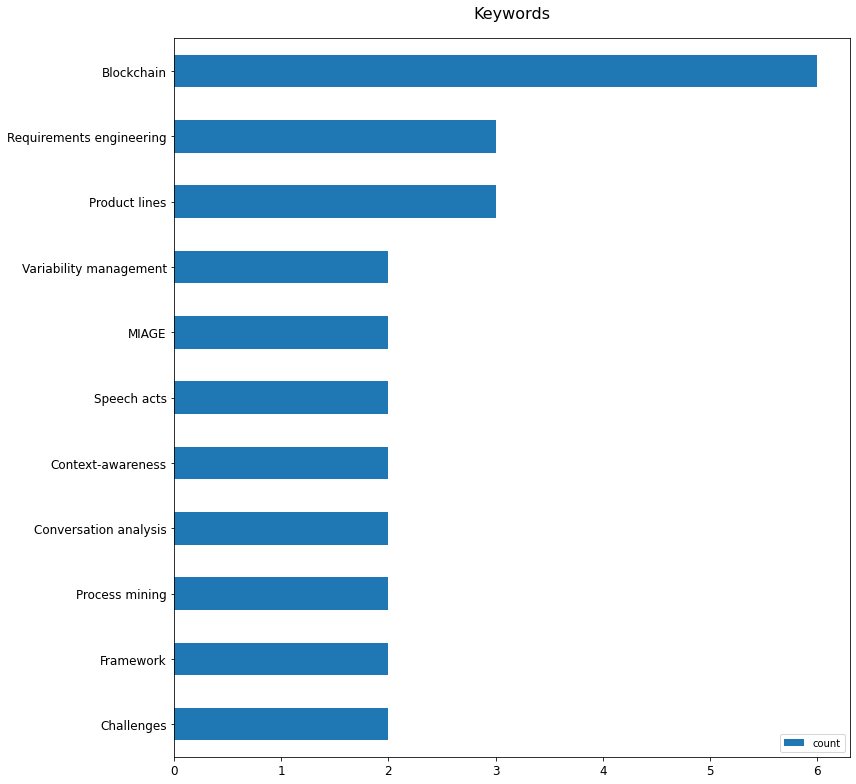

In [29]:
p = top_count_keywords.sort_values(by=['count'], ascending=True).plot(
    kind='barh',
    title='Keywords',
    x='keyword_s',
    y='count',
    xlabel='',
    ylabel='',
    figsize=(12, 11),
    rot=0,
    fontsize=12
)
p.set_title('Keywords', pad=20, fontdict={'fontsize': 16})
plt.tight_layout()
p.get_figure().savefig(f'./exports/keywords_repartition.png')

## Journals

### Journals occurrences 

In [30]:
journals = df_art[['journalTitle_s']].value_counts(dropna=False).to_frame(name='count').reset_index()
journals.to_csv(path_or_buf='./exports/journals.csv', index=False)
LOGGER.info('Number of journals : %d', journals["journalTitle_s"].size)
journals.head(n=5)

[2023-02-22 20:41:53][INFO ][<module>#3] Number of journals : 28


,journalTitle_s,count
0,Software and Systems Modeling,2
1,Complex Systems Informatics and Modeling Quart...,2
2,2022 IEEE/ACS 19th International Conference on...,1
3,International Journal of e-Collaboration,1
4,Revue ouverte d’ingénierie des systèmes d’info...,1


In [31]:
top_count_journals = journals[journals['count'] >= 1].sort_values(by=['count'], ascending=False)
top_count_journals

,journalTitle_s,count
0,Software and Systems Modeling,2
1,Complex Systems Informatics and Modeling Quart...,2
26,Blockchain: Research and Applications,1
25,Cogent Education,1
24,Communications in Computer and Information Sci...,1
23,Corpus Pragmatics,1
22,EAI Endorsed Transactions on Smart Cities,1
21,Empirical Software Engineering,1
20,Génie logiciel : le magazine de l'ingénierie d...,1
19,IEEE Access,1


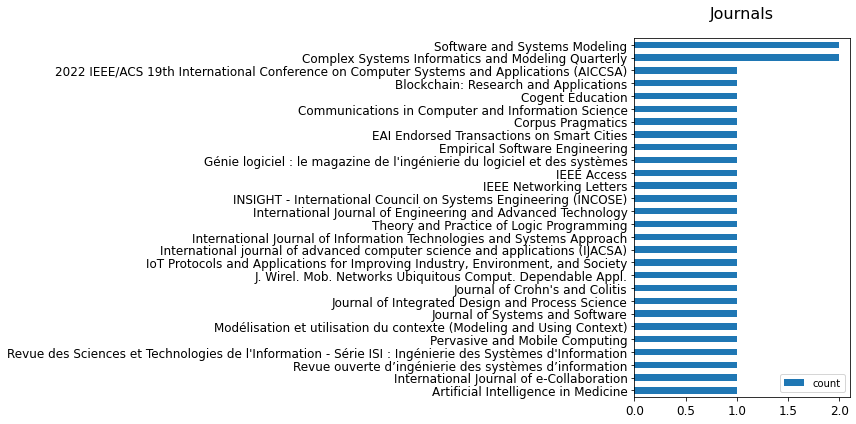

In [32]:
p = top_count_journals.sort_values(by=['count']).plot(
    kind='barh',
    title='Journals',
    x='journalTitle_s',
    y='count',
    xlabel='',
    ylabel='',
    figsize=(12, 6),
    fontsize=12
)
p.set_title('Journals', pad=20, fontdict={'fontsize': 16})
plt.tight_layout()
p.get_figure().savefig(f'./exports/journals_repartition.png')

### Journal without ISSN

In [33]:
journal_without_issns = df_art[df_art.journalIssn_s.isnull()][['uri_s', 'journalTitle_s']].reset_index(drop=True)
journal_without_issns.to_csv(f'./exports/journals_without_issn.csv', index=False)
journal_without_issns

,uri_s,journalTitle_s
0,https://hal.science/hal-02301045,International Journal of Engineering and Advan...
1,https://hal.science/hal-03566030,IoT Protocols and Applications for Improving I...
2,https://hal.science/hal-03451232,J. Wirel. Mob. Networks Ubiquitous Comput. Dep...
3,https://hal.science/hal-03520909,Blockchain: Research and Applications
4,https://hal.science/hal-01843035,EAI Endorsed Transactions on Smart Cities
5,https://hal.science/hal-02302992,Complex Systems Informatics and Modeling Quart...
6,https://hal.science/hal-03971602,2022 IEEE/ACS 19th International Conference on...
7,https://hal.science/hal-03116196,Revue ouverte d’ingénierie des systèmes d’info...


## JEL

In [34]:
%%script false --no-raise-error
# Number of Non NA Values
df_art[['uri_s', 'jel_s']].count()

In [35]:
%%script false --no-raise-error
jels = df_art[['uri_s', 'jel_s']].explode('jel_s')
jels.to_csv(path_or_buf='./exports/jels.csv', index=False)
jels = jels.dropna()
jels

In [36]:
%%script false --no-raise-error
jels['jel_s_code'] = jels['jel_s'].apply(lambda x: x.split('.')[0])
count_jels = jels.value_counts(subset=['jel_s_code']).to_frame(name='count').reset_index()
count_jels

In [37]:
%%script false --no-raise-error
p = count_jels.sort_values(by=['count']).plot(
    kind='barh',
    title='JEL',
    x='jel_s_code',
    y='count',
    xlabel='',
    ylabel='',
    figsize=(10, 5),
    fontsize=14,
    rot=0,
)
p.set_title('JEL codes', pad=20, fontdict={'fontsize': 16})
plt.tight_layout()
p.get_figure().savefig(f'./exports/jel_first_level_repartition.png')

## Funding

In [38]:
def funding_stats(dataframe: pd.core.frame.DataFrame,
                  filename: str,
                  columns: List[str],
                  occurence_params: Dict[str, Any] = dict(),
                  occurence_title_params: Dict[str, Any] = dict(),
                  repartition_params: Dict[str, Any] = dict(),
                  repartition_title_params: Dict[str, Any] = dict(),
                  repartition_group_min: int = 0):
    LOGGER.info(f'Start processing funding for output filename "%s" based on columns: %s', filename, columns)
    
    # Extract dataframe data
    exploded = dataframe.explode(columns)
    exploded = exploded[['uri_s'] + columns]
    DfOps(exploded.dropna()).csv(filename=f'fundings_{filename}_uri.csv', index=False)
    
    # Occurences stats
    occurence_exploded = exploded[columns].value_counts(dropna=True).to_frame(name='count').reset_index()
    DfOps(occurence_exploded).csv(filename=f'fundings_{filename}_occurence.csv', index=False)
    if not occurence_exploded.empty:
        occurence_default_params = dict(
            kind='pie',
            subplots=True,
            sharex=False,
            sharey=False,
            title='Occurence',
            ylabel='',
            labels=occurence_exploded[columns[0]],
            figsize=(12, 12),
            autopct='%1.1f%%',
            pctdistance=0.85,
            rotatelabels=True,
            labeldistance=1.02,
        )
        occurence_params = { **occurence_default_params, **occurence_params }
        axs = occurence_exploded['count'].plot(**{ **occurence_params, 'title': None })
        plt.tight_layout()
        axs[0].set_ylabel('')
        axs[0].set_title(**{
            **dict(
                label=occurence_params['title'],
                y=1.0,
                pad=-14,
                fontdict={'fontsize': 16}
            ),
            **occurence_title_params
        })
        occurence_png_target_file = f'./exports/fundings_{filename}_occurence.png' 
        plt.figure(1).savefig(occurence_png_target_file)
        plt.show()
        LOGGER.info('Saving figure to "%s"', occurence_png_target_file)
    else:
        LOGGER.info('Skip figure of occurence for "%s" as the dataframe is empty', filename)
        
    
    # Repartition of having value
    count_exploded = exploded.dropna()[['uri_s']].value_counts().to_frame(name='count').reset_index()
    count_exploded = dataframe.merge(count_exploded, how='left', on='uri_s')
    count_exploded = count_exploded[['uri_s', 'count']].fillna(0).astype({'count': int}).drop_duplicates()
    DfOps(count_exploded).csv(filename=f'fundings_{filename}_count.csv', index=False)
    
    repartition_count_exploded = count_exploded[['count']].value_counts().to_frame(name='number_of_count').reset_index()
    DfOps(repartition_count_exploded).csv(filename=f'fundings_{filename}_repartition.csv', index=False)
    
    if not repartition_count_exploded.empty:
        if repartition_group_min > 0:
            repartition_count_exploded = DfOps(repartition_count_exploded).group_min_values(
                label_column = 'count',
                value_column = 'number_of_count',
                min_value = repartition_group_min,
                min_label = lambda l: str(l)
            )
        repartition_default_params = dict(
            kind='pie',
            subplots=True,
            sharex=False,
            sharey=False,
            title='Repartition',
            ylabel='',
            labels=repartition_count_exploded['count'],
            figsize=(12, 12),
            autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * repartition_count_exploded['number_of_count'].sum() / 100)),
            pctdistance=0.8,
        )
        repartition_params = {**repartition_default_params, **repartition_params}
        axs = repartition_count_exploded['number_of_count'].plot(**{ **repartition_params, 'title': None })
        repartition_count_exploded_png_target_file = f'./exports/fundings_{filename}_repartition.png'
        plt.tight_layout()
        axs[0].set_ylabel('')
        axs[0].set_title(**{
            **dict(
                label=repartition_params['title'],
                y=1.0,
                pad=-14,
                fontdict={'fontsize': 16}
            ),
            **repartition_title_params
        })
        plt.figure(1).savefig(repartition_count_exploded_png_target_file)
        plt.show()
        LOGGER.info('Saving figure to "%s"', repartition_count_exploded_png_target_file)
    else:
        LOGGER.info('Skip figure of repartition for "%s" as the dataframe is empty', filename)
    
    LOGGER.info('End processing funding for filemane "%s" outputs', filename)


### ANR

[2023-02-22 20:41:54][INFO ][funding_stats#9] Start processing funding for output filename "anr_global" based on columns: ['anrProjectAcronym_s', 'anrProjectReference_s']
[2023-02-22 20:41:54][INFO ][csv#35] Export to CSV file: ./exports/fundings_anr_global_uri.csv (params: {'index': False}) (number of rows: 2)
[2023-02-22 20:41:54][INFO ][csv#35] Export to CSV file: ./exports/fundings_anr_global_occurence.csv (params: {'index': False}) (number of rows: 2)


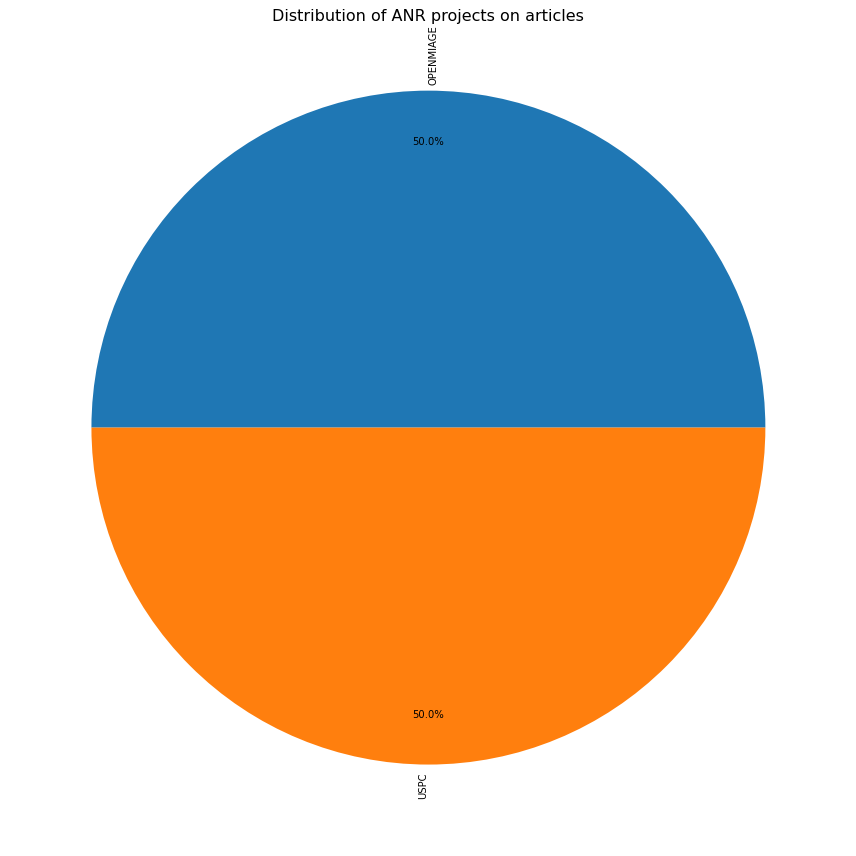

[2023-02-22 20:41:54][INFO ][funding_stats#50] Saving figure to "./exports/fundings_anr_global_occurence.png"
[2023-02-22 20:41:54][INFO ][csv#35] Export to CSV file: ./exports/fundings_anr_global_count.csv (params: {'index': False}) (number of rows: 30)
[2023-02-22 20:41:54][INFO ][csv#35] Export to CSV file: ./exports/fundings_anr_global_repartition.csv (params: {'index': False}) (number of rows: 2)


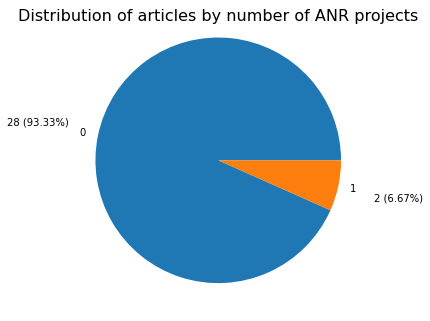

[2023-02-22 20:41:54][INFO ][funding_stats#100] Saving figure to "./exports/fundings_anr_global_repartition.png"
[2023-02-22 20:41:54][INFO ][funding_stats#104] End processing funding for filemane "anr_global" outputs


In [39]:
funding_stats(
    dataframe=df_art,
    columns=['anrProjectAcronym_s', 'anrProjectReference_s'],
    filename='anr_global',
    occurence_params=dict(title='Distribution of ANR projects on articles'),
    repartition_params=dict(title='Distribution of articles by number of ANR projects', figsize=(6,6), pctdistance=1.5),
)

### European

In [40]:
%%script false --no-raise-error
funding_stats(
    dataframe = df_art,
    columns = ['europeanProjectAcronym_s', 'europeanProjectReference_s'],
    filename = 'european_global',
    occurence_params = dict(
        title = 'Distribution of European projects on articles',
        figsize=(8, 8)
    ),
    occurence_title_params = dict(
        pad = 30
    ),
    repartition_params = dict(
        title = 'Distribution of articles by number of European projects',
        figsize = (10, 10),
        pctdistance = 1.5
    ),
)

In [41]:
%%script false --no-raise-error
funding_stats(
    dataframe = df_art,
    columns = ['europeanProjectAcronym_s', 'europeanProjectReference_s'],
    filename = 'european_global_top',
    occurence_params = dict(
        title = 'Distribution of European projects on articles',
        figsize = (8, 8)
    ),
    occurence_title_params = dict(
        pad = 30
    ),
    repartition_params = dict(
        title = 'Distribution of articles\nby number of European projects',
        figsize = (7, 7),
        pctdistance = 1.6
    ),
    repartition_group_min = 6,
)

### Others

In [42]:
%%script false --no-raise-error
other_fundings = df_art.explode(['funding_s'])
other_fundings = other_fundings[['uri_s', 'funding_s']]
other_fundings.dropna().to_csv(path_or_buf='./exports/fundings_other_uri.csv', index=False)
other_fundings = other_fundings[['funding_s']].value_counts(dropna=False).to_frame(name='count').reset_index()
other_fundings.to_csv(path_or_buf='./exports/fundings_other_stats.csv', index=False)
other_fundings.head(n=5)

## Collaborations

### Structure/institution: Country (instStructCountry_s)

An article, may have several `instStructCountry_s`.

We explode the dataset based on the field `instStructCountry_s` to have only one country by row.

In [43]:
collaboration_struct_countries = df_art[['uri_s', 'instStructCountry_s']]
collaboration_struct_countries = collaboration_struct_countries.explode(['instStructCountry_s'])
collaboration_struct_countries

,uri_s,instStructCountry_s
0,https://hal.science/hal-02301045,fr
0,https://hal.science/hal-02301045,ma
0,https://hal.science/hal-02301045,ma
1,https://hal.science/hal-03566030,fr
1,https://hal.science/hal-03566030,fr
...,...,...
29,https://hal.science/hal-02294967,cn
29,https://hal.science/hal-02294967,fr
29,https://hal.science/hal-02294967,fr
29,https://hal.science/hal-02294967,gr


In [44]:
collaboration_struct_country_values = collaboration_struct_countries[['instStructCountry_s']].value_counts().to_frame(name='count').reset_index()
collaboration_struct_country_values.to_csv(f'./exports/colloborations_inst_struct_country.csv', index=False)
collaboration_struct_country_values.head(n=5)

,instStructCountry_s,count
0,fr,93
1,ma,8
2,es,4
3,si,2
4,tn,2


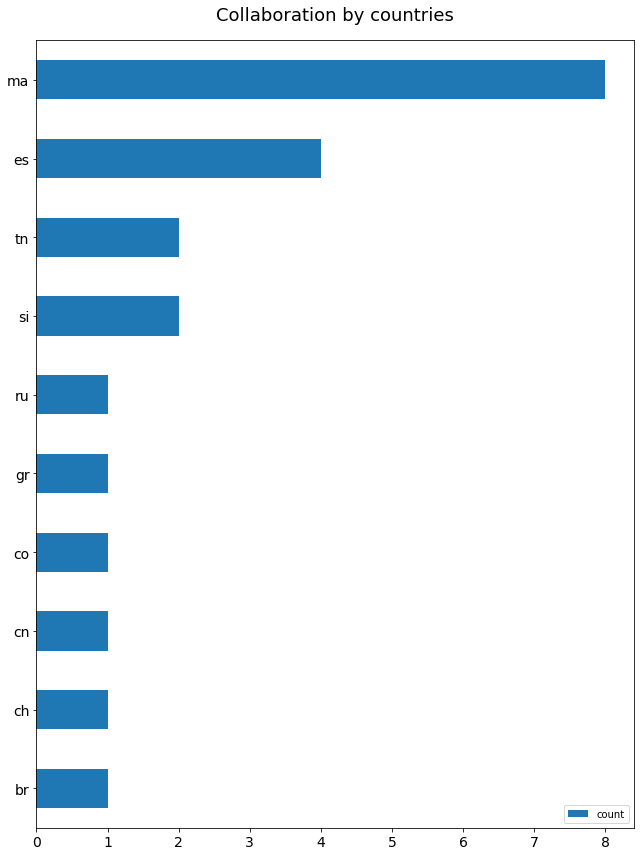

In [45]:
p = collaboration_struct_country_values[(collaboration_struct_country_values.instStructCountry_s != 'fr')].sort_values(by=['count'], ascending=True).plot(
    kind='barh',
    title='Collaboration by countries',
    x='instStructCountry_s',
    y='count',
    xlabel='',
    ylabel='',
    figsize=(9, 12),
    fontsize=14,
    rot=0,
)
p.set_title('Collaboration by countries',pad=20, fontdict={'fontsize':18})
plt.tight_layout()
p.get_figure().savefig(f'./exports/collaboration_struct_country_count.png')

### Structure/institution: Name (instStructName_s)

An article, may have several `instStructName_s`.

We explode the dataset based on the field `instStructName_s` to have only one structure by row.

In [46]:
collaboration_struct_names = df_art[['uri_s', 'instStructName_s']]
collaboration_struct_names = collaboration_struct_names.explode(['instStructName_s'])
collaboration_struct_names

,uri_s,instStructName_s
0,https://hal.science/hal-02301045,Université Paris 1 Panthéon-Sorbonne
0,https://hal.science/hal-02301045,"Univ. Mohammed V- Rabat, EMI, SIWEB Team - Rab..."
0,https://hal.science/hal-02301045,"Univ. Mohammed V- Rabat, EMI, SIWEB Team - Rab..."
1,https://hal.science/hal-03566030,Université Paris 1 Panthéon-Sorbonne
1,https://hal.science/hal-03566030,Université Paris 1 Panthéon-Sorbonne
...,...,...
29,https://hal.science/hal-02294967,Beijing Institute of Technology
29,https://hal.science/hal-02294967,Eurecom [Sophia Antipolis]
29,https://hal.science/hal-02294967,Université Paris 1 Panthéon-Sorbonne
29,https://hal.science/hal-02294967,Athens University of Economics and Business


In [47]:
collaboration_struct_name_aggregation_min = 0
collaboration_struct_name_values = collaboration_struct_names[['instStructName_s']].value_counts().to_frame(name='count').reset_index()
collaboration_struct_name_values.to_csv(f'./exports/colloborations_inst_struct_name.csv', index=False)
collaboration_struct_name_values = collaboration_struct_name_values[(collaboration_struct_name_values.instStructName_s != 'Centre National de la Recherche Scientifique')]
collaboration_struct_name_values = collaboration_struct_name_values[(collaboration_struct_name_values.instStructName_s != 'Université Paris 1 Panthéon-Sorbonne')]
# Retrieve small collaboration to create a new row 'others'
collaboration_struct_name_others = collaboration_struct_name_values[(collaboration_struct_name_values['count'] <= collaboration_struct_name_aggregation_min)]
collaboration_struct_name_others_size = collaboration_struct_name_others['instStructName_s'].size
collaboration_struct_name_others = pd.DataFrame(
    dict(
        instStructName_s=f'Others ({collaboration_struct_name_others_size})',
        count=collaboration_struct_name_others['count'].sum()
    ),
    index=[0]
)
# Cleanup base df for collaboration
collaboration_struct_name_top = collaboration_struct_name_values[(collaboration_struct_name_values['count'] > collaboration_struct_name_aggregation_min)]
collaboration_struct_name_values = pd.concat([collaboration_struct_name_top, collaboration_struct_name_others], ignore_index=True)
collaboration_struct_name_values = collaboration_struct_name_values.sort_values(by=['count'], ascending=False)
collaboration_struct_name_values.to_csv(f'./exports/colloborations_inst_struct_name_filtered_{collaboration_struct_name_aggregation_min}.csv', index=False)
collaboration_struct_name_values.head(n=5)

,instStructName_s,count
0,École Nationale Supérieure de Techniques Avanc...,7
1,"Univ. Mohammed V- Rabat, EMI, SIWEB Team - Rab...",6
2,IMT Atlantique,4
3,Université de Brest,4
4,Université de Bretagne Sud,4


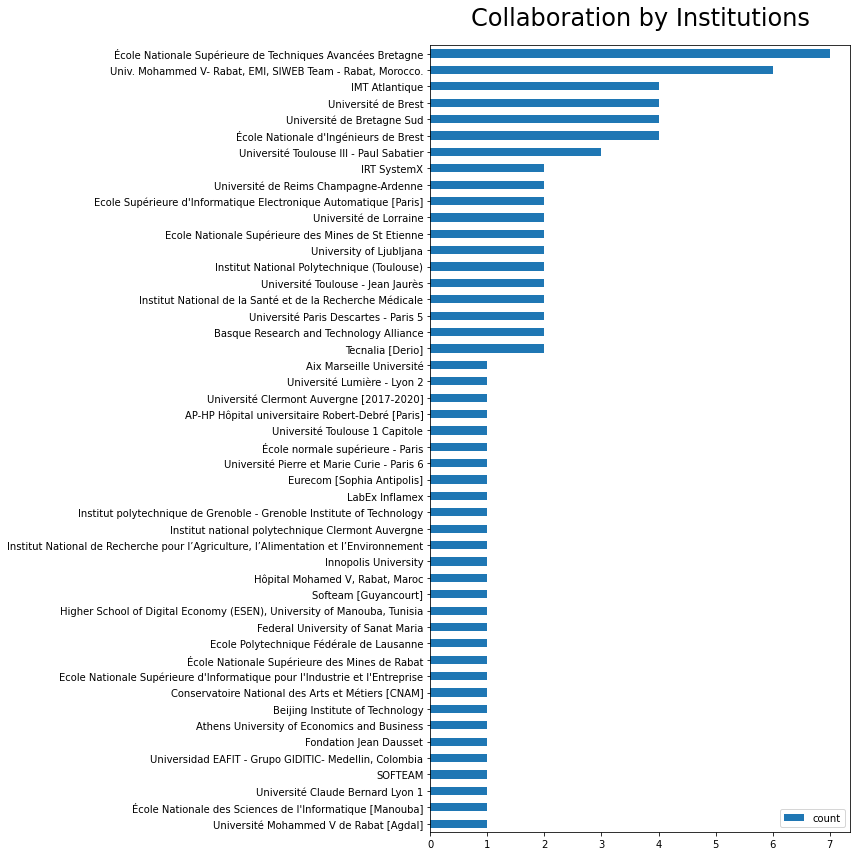

In [48]:
p = collaboration_struct_name_top.sort_values(by=['count']).plot(
    kind='barh',
    title='Collaboration by Institutions',
    x='instStructName_s',
    y='count',
    xlabel='',
    ylabel='',
    figsize=(12, 12)
)
p.set_title('Collaboration by Institutions', pad=20, fontdict={'fontsize':24})
plt.tight_layout()
p.get_figure().savefig(f'./exports/collaboration_struct_name_count_without_others.png')

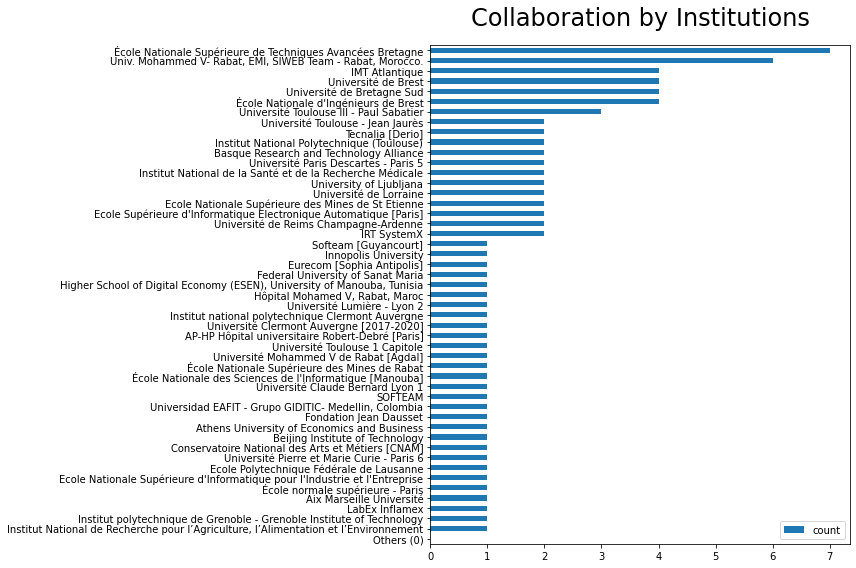

In [49]:
p = collaboration_struct_name_values.sort_values(by=['count']).plot(
    kind='barh',
    title='Collaboration by Institutions',
    x='instStructName_s',
    y='count',
    xlabel='',
    ylabel='',
    figsize=(12, 8)
)
p.set_title('Collaboration by Institutions', pad=20, fontdict={'fontsize':24})
plt.tight_layout()
p.get_figure().savefig(f'./exports/collaboration_struct_name_count.png')

## Full text

Also named attached files ...

An article may have multiple attached files. We will count the number of attached files here by document.

In [50]:
def full_text(dataframe,
              title: str,
              filename: Optional[str] = None,
              params: Dict[str, Any] = dict()):
    
    filename = (filename or '').strip()
    prefix_filename = f'full_text_{filename}' if len(filename) > 0 else 'full_text'
    
    attached_files = dataframe[['uri_s', 'files_s']].copy()
    attached_files['attached_files_count'] = attached_files['files_s'].apply(lambda x: len(x) if pd.notnull(x) else 0)
    DfOps(attached_files[['uri_s', 'attached_files_count']]).csv(filename=f'{prefix_filename}.csv', index=False)
     
    attached_files_number = attached_files['attached_files_count'].value_counts().sort_index()
    DfOps(attached_files_number).csv(filename=f'{prefix_filename}_distribution.csv', index=False)
    
    default_params = dict(   
        kind='pie',
        subplots=True,
        sharex=False,
        sharey=False,
        #title=title,
        ylabel='',
        labels=attached_files_number.index.tolist(),
        figsize=(6, 6),
        autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * attached_files_number.sum() / 100)),
        pctdistance=0.7,
        fontsize=14,
    )
    attached_files_number_png_target_file = f'./exports/{prefix_filename}_distribution.png'
    axs = attached_files_number.plot(**{**default_params, **params})
    plt.tight_layout()
    axs[0].set_ylabel('')
    axs[0].set_title(
        label = title,
        y = 1.0,
        pad = 6,
        fontdict = {'fontsize': 16},
    )
    plt.figure(1).savefig(attached_files_number_png_target_file)
    plt.show()
    LOGGER.info('Saving figure to : "%s"', attached_files_number_png_target_file)
    return attached_files 

[2023-02-22 20:41:56][INFO ][csv#35] Export to CSV file: ./exports/full_text.csv (params: {'index': False}) (number of rows: 30)
[2023-02-22 20:41:56][INFO ][csv#35] Export to CSV file: ./exports/full_text_distribution.csv (params: {'index': False}) (number of rows: 2)


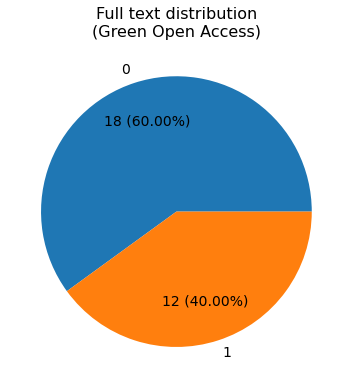

[2023-02-22 20:41:56][INFO ][full_text#41] Saving figure to : "./exports/full_text_distribution.png"


,uri_s,files_s,attached_files_count
0,https://hal.science/hal-02301045,NaN,0
1,https://hal.science/hal-03566030,[https://hal.science/hal-03566030/file/2021-Gu...,1
2,https://hal.science/hal-03451232,NaN,0
3,https://hal.science/hal-03520909,[https://hal.science/hal-03520909/file/BC_Patt...,1
4,https://hal.univ-lorraine.fr/hal-01722928,[https://hal.univ-lorraine.fr/hal-01722928/fil...,1
5,https://hal-paris1.archives-ouvertes.fr/hal-01...,NaN,0
6,https://hal.science/hal-03526302,[https://hal.science/hal-03526302/file/INSIGHT...,1
7,https://hal.science/hal-01843035,NaN,0
8,https://hal-paris1.archives-ouvertes.fr/hal-03...,NaN,0
9,https://hal-paris1.archives-ouvertes.fr/hal-03...,NaN,0


In [51]:
full_text(
    dataframe=df_art,
    title='Full text distribution\n(Green Open Access)',
    params=dict(
        figsize=(5,5),
        pctdistance=0.70,
        labeldistance=1.1
    )
)

## Open Access

[2023-02-22 20:41:56][INFO ][csv#35] Export to CSV file: ./exports/open_access_on_articles_distribution.csv (params: {'index': False}) (number of rows: 2)


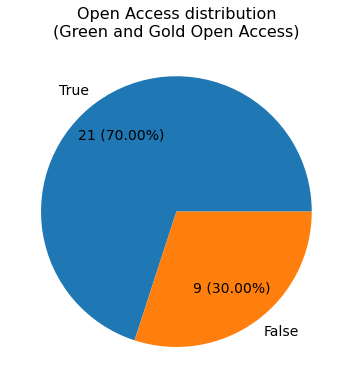

[2023-02-22 20:41:56][INFO ][open_access#38] Saving figure to: "./exports/open_access_on_articles_distribution.png"


,index,count
0,True,21
1,False,9


In [52]:
open_access(
    dataframe=df_art,
    filename='on_articles',
    title='Open Access distribution\n(Green and Gold Open Access)',
    params=dict(
        figsize=(5,5),
        pctdistance=0.70,
        labeldistance=1.1
    )
)

## Ranking



In [53]:
def create_ranking_journals_df(dataframe: pd.core.frame.DataFrame,
                               filename_prefix: Optional[str] = None,
                               excludes: Optional[List[str]] = None):
    excludes = excludes or []
    includes = [i for i in ['ECONLIT', 'MATHSCINET', 'SCIMAGO', 'HCERES', 'CNRS_S37'] if i not in excludes]
    LOGGER.info('Create ranking dataframe including: %s (excludes=%s)', includes, excludes)
    
    
    ranking_journals = dataframe[['uri_s', 'journalTitle_s', 'journalIssn_s']].copy()
    ranking_journals['ISSN'] = ranking_journals['journalIssn_s']
    # Econlit
    if 'ECONLIT' in includes:
        ranking_journals = ranking_journals.merge(econlit_df, how='left', on='ISSN', validate='many_to_one')
        ranking_journals['ECONLIT'] = ranking_journals['Title'].notnull()
        ranking_journals = ranking_journals.drop(columns=['Title'])
    
    # MathSciNet
    if 'MATHSCINET' in includes:
        ranking_journals = ranking_journals.merge(mathscinet_df, how='left', on='ISSN', validate='many_to_one')
        ranking_journals['MATHSCINET'] = ranking_journals['Title'].notnull()
        ranking_journals = ranking_journals.drop(columns=['Title'])
    
    # Scimago
    if 'SCIMAGO' in includes:
        ranking_journals = ranking_journals.merge(scimagojr_df, how='left', on='ISSN', validate='many_to_one')
        ranking_journals['SCIMAGO'] = ranking_journals['Title'].notnull()
        ranking_journals = ranking_journals.drop(columns=['Title']).rename(columns={'CATEGORIES': 'SCIMAGO_CATEGORIES'})
    
    # HCERES
    if 'HCERES' in includes:
        ranking_journals = ranking_journals.merge(hceres_df, how='left', on='ISSN', validate='many_to_one')
        ranking_journals = ranking_journals.drop(columns=['Title'])
        ranking_journals['HCERES'] = ranking_journals['HCERES_2021'].notnull()
        ranking_journals = ranking_journals.rename(columns={'HCERES_2021': 'HCERES_RANK', 'CoNRS_2020': 'HCERES_CONRS_RANK', 'FNEGE_2019': 'HCERES_FNEGE_RANK'})
    
    # CNRS_S37
    if 'CNRS_S37' in includes:
        ranking_journals = ranking_journals.merge(cnrs_s37_df, how='left', on='ISSN', validate='many_to_one')
        ranking_journals = ranking_journals.drop(columns=['Title'])
        ranking_journals['CNRS_S37'] = ranking_journals['domaine'].notnull()
        ranking_journals = ranking_journals.rename(columns={'domaine': 'CNRS_S37_DOMAINE', 'cat': 'CNRS_S37_CAT'})
        
    
    # HCERES + Scimago + MathSciNet + Econlit + CNRS s37 (if includes)
    ranking_journals['NUMBER_OF_REFERENTIALS'] = ranking_journals[includes].apply(lambda x: x.sum(), axis=1, raw=True)
    
    # Cleanup data
    ranking_journals = ranking_journals.drop(columns=['ISSN'])
    if filename_prefix:
        DfOps(ranking_journals).csv(filename=f'{filename_prefix}.csv', index=False)
    
    return ranking_journals

In [54]:
def journals_ranking_plot(dataframe: pd.core.frame.DataFrame,
                          titles: Dict[str, str] = dict(),
                          filename_prefix: str = 'rankings'):
    titles = titles or {}
    possible_columns = ['MATHSCINET', 'SCIMAGO', 'ECONLIT', 'HCERES', 'CNRS_S37']
    columns = [i for i in possible_columns if i in dataframe]
    
    if not columns:
        LOGGER.warning('Cannot plot journals ranking as there is no columns in: %s', possible_columns)
        return
    
    target_file_filtered = f'./exports/{filename_prefix}_filtered.csv'
    DfOps(dataframe[['uri_s'] + columns]).csv(filename=f'{filename_prefix}_filtered.csv', index=False)
    
    ranking_aggregation_transposed = dataframe[columns].apply(pd.Series.value_counts).transpose().fillna(0)
    DfOps(ranking_aggregation_transposed).csv(filename=f'{filename_prefix}_count.csv', index=False)

    true_values = ranking_aggregation_transposed[True].tolist()
    true_labels = round(100 * ranking_aggregation_transposed[True] / ranking_aggregation_transposed.sum(axis='columns'), 1)
    true_labels = ranking_aggregation_transposed[True].combine(true_labels, func=lambda v, p: f'{v} ({p}%)').tolist()

    false_values = ranking_aggregation_transposed[False].tolist()
    false_labels = round(100 * ranking_aggregation_transposed[False] / ranking_aggregation_transposed.sum(axis='columns'), 1)
    false_labels = ranking_aggregation_transposed[False].combine(false_labels, func=lambda v, p: f'{v} ({p}%)').tolist()

    ind = np.arange(len(true_values)) 
    width = 0.60

    fig, ax = plt.subplots(figsize=(12,6))

    true_plot = ax.barh(columns, true_values, width, label='True', linewidth=0 )
    false_plot = ax.barh(columns, false_values, width, left=true_values, label='False', linewidth=0)

    title = 'Articles ranking'
    LOGGER.debug('Retrieve title using key: %s (default: %s)', title, title)
    title = titles.get('Articles ranking', 'Articles ranking')
    ax.set_title(title, pad=10, fontsize=18)
    ax.set_xlabel('Articles', fontsize=13)
    ax.bar_label(true_plot, label_type='center', fontsize=13, labels=true_labels)
    ax.bar_label(false_plot, label_type='center', fontsize=13, labels=false_labels)
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=13)
    fig.tight_layout()
    target_file_general = f'./exports/{filename_prefix}_general.png'
    fig.savefig(target_file_general)
    LOGGER.info('Saved figure at "%s"', target_file_general)
    plt.show()

In [55]:
def cnrs_s37_ranking_plot(dataframe: pd.core.frame.DataFrame,
                        titles: Dict[str, str] = dict(),
                        filename_prefix: str = 'rankings',
                        params:Dict[str, Any] = dict()):
    if 'CNRS_S37_CAT' not in dataframe:
        LOGGER.warning('Skip plotting CNRS_S37 as "CNRS_S37_CAT" is not a column of the DataFrame')
        return
    
    titles = titles or {}
    title = 'CNRS S37 articles ranking'
    LOGGER.debug('Retrieve title using key: %s (default=%s)', title, title) 
    title = titles.get(title, title)
    
    LOGGER.info('Create ranking plot "%s" for CNRS (params=%s)', title, params)
    cnrs_s37_rankings = dataframe['CNRS_S37_CAT'].dropna().value_counts().to_frame(name='count').reset_index().rename(columns={'index': 'cat'})
    DfOps(cnrs_s37_rankings, prefix=filename_prefix) \
        .csv(filename=f'{filename_prefix}_cnrs_s37.csv', index=False) \
        .pie(
            label_column = 'cat',
            column = 'count', 
            title = title,
            sort_by = ['cat'],
            plot_params = {**dict(figsize=(6, 6)), **params},
        #    title_params: Dict[str, Any] = None,
        #    sort_params: Dict[str, Any] = None,
        )


In [56]:
def hceres_ranking_plot(dataframe: pd.core.frame.DataFrame,
                        titles: Dict[str, str] = dict(),
                        filename_prefix: str = 'rankings',
                        params:Dict[str, Any] = dict()):
    if 'HCERES_RANK' not in dataframe:
        LOGGER.warning('Skip plotting HCERES as "HCERES_RANK" is not a column of the DataFrame')
        return
    
    titles = titles or {}
    title = 'HCERES articles ranking'
    LOGGER.debug('Retrieve title using key: %s (default=%s)', title, title) 
    title = titles.get(title, title)
    
    LOGGER.info('Create ranking plot "%s" for HCERES (params=%s)', title, params)
    hceres_rankings = dataframe['HCERES_RANK'].dropna().value_counts().sort_index()
    DfOps(hceres_rankings.to_frame(name='count_hceres_ranks')).csv(filename=f'{filename_prefix}_hceres.csv', index=False)
    default_params = dict(
        kind='pie',
        subplots=True,
        sharex=False,
        sharey=False,
        ylabel='',
        labels=hceres_rankings.index.tolist(),
        figsize=(6, 6),
        autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * hceres_rankings.sum() / 100)),
        pctdistance=0.6,
        fontsize=14,
    )
    hceres_rankings.plot(**{**default_params, **params})
   
    plt.figure(1).axes[0].set_title(title, pad=0, fontdict={'fontsize':15})
    plt.tight_layout()
    target_file_png = f'./exports/{filename_prefix}_hceres.png'
    plt.figure(1).savefig(target_file_png)
    LOGGER.info('Saved figure at "%s"', target_file_png)
    plt.show()

In [57]:
def create_scimajo_df(dataframe: pd.core.frame.DataFrame,
                      filename_prefix: str = 'rankings',
                      suffix: int = 0,
                      quantile: float = 0.0) -> pd.core.frame.DataFrame:
    
    if 'SCIMAGO_CATEGORIES' not in dataframe:
        LOGGER.warning('Cannot create scimajo dataframe as "SCIMAGO_CATEGORIES" column doesn\'t exist')
        return pd.DataFrame()
    
    scimagojr_categories = dataframe[['uri_s', 'journalTitle_s', 'SCIMAGO_CATEGORIES']].copy().dropna()
    scimagojr_categories['CATEGORY'] = scimagojr_categories['SCIMAGO_CATEGORIES'].str.split(';')
    scimagojr_categories = scimagojr_categories.explode('CATEGORY')
    scimagojr_categories['CATEGORY'] = scimagojr_categories['CATEGORY'].str.strip()
    scimagojr_categories['SCIMAGO_JOURNAL_RANKING'] = scimagojr_categories['CATEGORY'].str.extract('^.*\((?P<sjr>Q[1-4])\)\s*$')
    scimagojr_categories['CATEGORY_WITHOUT_SJR'] = scimagojr_categories['CATEGORY'].str.extract('^(?P<cat>.*)\s+\(Q[1-4]\)\s*$')
    scimagojr_categories = scimagojr_categories.reset_index(drop=True)
    target_file = f'./exports/{filename_prefix}_scimago.csv'
    scimagojr_categories.to_csv(target_file, index=False)
    LOGGER.info('Saved CSV at "%s"', target_file)
    
    # Add a category others when we have to small values
    if quantile > 0:
        LOGGER.info('Rework dataframe to group the less used categories (quantile=%f)', quantile)
        scimagojr_category_names = scimagojr_categories['CATEGORY_WITHOUT_SJR'].value_counts()
        bottom_value = scimagojr_category_names.quantile(q=quantile)
        less_freq_scimagojr_category_names = scimagojr_category_names[scimagojr_category_names <= bottom_value]
        scimagojr_categories.loc[scimagojr_categories['CATEGORY_WITHOUT_SJR'].isin(less_freq_scimagojr_category_names.index.tolist())] = "Others"
    
    target_file_filtered = f'./exports/{filename_prefix}_scimago_filtered_{suffix}.csv'
    scimagojr_categories.to_csv(target_file_filtered, index=False)
    LOGGER.info('Saved CSV at "%s', target_file_filtered)
    
    # Create a new column with category with percent (for the occurence of this category)
    scimagojr_category_names = scimagojr_categories['CATEGORY_WITHOUT_SJR'].value_counts().to_frame().reset_index()
    scimagojr_category_names = scimagojr_category_names.rename(columns={'index': 'CATEGORY_WITHOUT_SJR', 'CATEGORY_WITHOUT_SJR': 'CATEGORY_WITHOUT_SJR_COUNT'})
    scimagojr_category_names['CATEGORY_WITHOUT_JSR_PERCENT'] = scimagojr_category_names.apply(
        lambda row: '{n} - {v} ({p}%)'.format(
            n = row['CATEGORY_WITHOUT_SJR'],
            v = row['CATEGORY_WITHOUT_SJR_COUNT'],
            p = round(100 * row['CATEGORY_WITHOUT_SJR_COUNT'] / scimagojr_category_names['CATEGORY_WITHOUT_SJR_COUNT'].sum(), 1)
        ),
        axis='columns'
    )

    # Merge with initial dataframe
    scimagojr_categories = scimagojr_categories.merge(scimagojr_category_names, how='inner', on=['CATEGORY_WITHOUT_SJR'])
    
    return scimagojr_categories

In [58]:
def scimago_ranking_plot(dataframe: pd.core.frame.DataFrame,
                         titles: Dict[str, str] = dict(),
                         filename_prefix: str = 'rankings',
                         suffix: int = 0,
                         category_params:Dict[str, Any] = dict()):
    if 'CATEGORY_WITHOUT_JSR_PERCENT' not in dataframe:
        LOGGER.warning('Skip plotting Scimago as "CATEGORY_WITHOUT_JSR_PERCENT" is not a column of the DataFrame')
    
    titles = titles or {}
    
    # Fig 1 : Category
    scimago_category_names = dataframe['CATEGORY_WITHOUT_JSR_PERCENT'].value_counts()
    default_category_params = dict(
        kind='pie',
        subplots=True,
        sharex=False,
        sharey=False,
        ylabel='',
        labels=scimago_category_names.index.tolist(),
        figsize=(18, 12),
        autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * scimago_category_names.sum() / 100)),
        pctdistance=0.9,
        labeldistance=None,
        legend=True
    )
    
    title_categories = 'Scimago JCR: categories'
    LOGGER.debug('Retrieve title using key: %s (default=%s)', title_categories, title_categories)
    title_categories = titles.get(title_categories, title_categories)
    target_file_categories = f'./exports/{filename_prefix}_scimago_categories_{suffix}.png'
    
    scimago_category_names.plot(**{**default_category_params, **category_params})
    plt.legend(loc='best', bbox_to_anchor=(0.1, 0.9))
    plt.figure(1).axes[0].set_title(title_categories, pad=0, fontdict={'fontsize':15})
    plt.tight_layout()
    
    plt.figure(1).savefig(target_file_categories)
    LOGGER.info('Saved figure at "%s"', target_file_categories)
    plt.show()
    
    # Fig 2 : SJR Repartition
    scimajo_journal_rankings = dataframe['SCIMAGO_JOURNAL_RANKING'].value_counts()
    scimajo_journal_rankings.plot(
        kind='pie',
        subplots=True,
        sharex=False,
        sharey=False,
        ylabel='',
        labels=scimajo_journal_rankings.index.tolist(),
        figsize=(6, 6),
        autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * scimajo_journal_rankings.sum() / 100)),
        pctdistance=0.7,
        labeldistance=1.1,
    )
    
    title_quartiles = 'Scimago JCR: quartiles'
    LOGGER.debug('Retrieve title using key: %s (default=%s)', title_quartiles, title_quartiles)
    title_quartiles = titles.get(title_quartiles, title_quartiles)
    target_file_quartiles = f'./exports/{filename_prefix}_scimago_sjr_q_score_{suffix}.png'
    
    plt.figure(1).axes[0].set_title(title_quartiles, pad=0, fontdict={'fontsize':15})
    plt.tight_layout()
    plt.figure(1).savefig(target_file_quartiles)
    LOGGER.info('Saved figure at "%s"', target_file_quartiles)
    plt.show()

In [59]:
def cross_referentials_plot(dataframe: pd.core.frame.DataFrame,
                            titles: Dict[str, str] = dict(),
                            filename_prefix: str = 'rankings'):
    
    titles = titles or {}
    title = 'Distribution of articles'
    LOGGER.debug('Retrieve title using key: %s (default=%s)', title, title)
    title = titles.get(title, title)
    target_file = f'./exports/{filename_prefix}_distribution_of_articles_in_journal_classification_referentials.png'
    
    cross_ref_s = dataframe['NUMBER_OF_REFERENTIALS'].value_counts().sort_index()
    cross_ref_s.plot(
        kind='pie',
        subplots=True,
        sharex=False,
        sharey=False,
        ylabel='',
        labels=cross_ref_s.index.tolist(),
        figsize=(6, 6),
        autopct=lambda p: '{total} ({p:.2f}%)'.format(p=p, total=round(p * cross_ref_s.sum() / 100)),
        pctdistance=0.7,
        labeldistance=1.1,
    )
    plt.figure(1).axes[0].set_title(title, pad=0, fontdict={'fontsize':15})
    plt.tight_layout()
    plt.figure(1).savefig(target_file)
    LOGGER.info('Saved figure at "%s"', target_file)
    plt.show()

In [60]:
def scimago_hceres_matrix(dataframe: pd.core.frame.DataFrame,
                          filename_prefix: str = 'rankings') -> pd.core.frame.DataFrame:
    if 'HCERES_RANK' not in dataframe or 'SJR_BEST_QUARTILE' not in dataframe:
        LOGGER.warning('Cannot create a matrix for HCERES*Scimago Best Quartile as current dataframe doesn\'t have the columns')
        return pd.DataFrame()

    target_base_file = f'./exports/{filename_prefix}_hceres_scimago_matrix'
    LOGGER.info('Create Scimago / HCERES matrix')
    ranking_scimago_hceres_df = dataframe[['HCERES_RANK', 'SJR_BEST_QUARTILE']].fillna('NON REFERENCE')
    ranking_scimago_hceres_df = ranking_scimago_hceres_df.value_counts(dropna=False)
    
    ranking_scimago_hceres_df.to_excel(f'{target_base_file}.xlsx')
    LOGGER.info('Saved Excel at "%s.xlsx"', target_base_file)
    
    ranking_scimago_hceres_df = ranking_scimago_hceres_df.unstack(fill_value=0)
    ranking_scimago_hceres_df.to_excel(f'{target_base_file}_2.xlsx')
    LOGGER.info('Saved Excel at "%s_2.xlsx"', target_base_file)
    return ranking_scimago_hceres_df

In [61]:
def rankings(dataframe: pd.core.frame.DataFrame,
             titles: Dict[str, str] = dict(),
             excludes: List[str] = [],
             filename_prefix: str = 'rankings',
             hceres_category_params: Dict[str, Any] = dict(),
             cnrs_s37_category_params: Dict[str, Any] = dict(),):
    LOGGER.info('Process ranking (filename_prefix=%s, titles=%s)', filename_prefix, titles)
    rankings_journals = create_ranking_journals_df(
        dataframe = dataframe,
        excludes = excludes,
        filename_prefix = filename_prefix
    )
    journals_ranking_plot(
        dataframe = rankings_journals,
        titles = titles,
        filename_prefix = filename_prefix
    )
    hceres_ranking_plot(
        dataframe = rankings_journals,
        titles = titles,
        filename_prefix = filename_prefix,
        params = hceres_category_params
    )
    cnrs_s37_ranking_plot(
        dataframe = rankings_journals,
        titles = titles,
        filename_prefix = filename_prefix,
        params = cnrs_s37_category_params
    )
    cross_referentials_plot(
        dataframe = rankings_journals,
        titles = titles,
        filename_prefix = filename_prefix
    )
    return rankings_journals

In [62]:
def scimago_rankings(dataframe: pd.core.frame.DataFrame,
                     titles: Dict[str, str] = dict(),
                     filename_prefix: str = 'rankings',
                     suffix: int = 0,
                     quantile: float = 0.0,
                     category_params: Dict[str, Any] = dict()):
    # The input dataframe should be a return of create_ranking_journals_df or rankings
    LOGGER.info('Process scimago rankings (filename_prefix=%s, titles=%s)', filename_prefix, titles) 
    scimajo_df = create_scimajo_df(
        dataframe=dataframe,
        filename_prefix=filename_prefix,
        suffix=suffix,
        quantile=quantile
    )
    scimago_ranking_plot(
        dataframe=scimajo_df,
        titles=titles,
        filename_prefix=filename_prefix,
        suffix=suffix,
        category_params=category_params
    )

### Using all ranking systems

[2023-02-22 20:41:56][INFO ][rankings#7] Process ranking (filename_prefix=rankings_all, titles={'Articles ranking': 'Distribution of articles\nby journal rating reference system', 'HCERES articles ranking': 'Distribution of articles\nfor the HCERES Vague B 2021 rating reference system', 'Distribution of articles': 'Distribution of articles\nin journal rating reference systems'})
[2023-02-22 20:41:56][INFO ][create_ranking_journals_df#6] Create ranking dataframe including: ['ECONLIT', 'MATHSCINET', 'SCIMAGO', 'HCERES', 'CNRS_S37'] (excludes=[])
[2023-02-22 20:41:56][INFO ][csv#35] Export to CSV file: ./exports/rankings_all.csv (params: {'index': False}) (number of rows: 30)
[2023-02-22 20:41:56][INFO ][csv#35] Export to CSV file: ./exports/rankings_all_filtered.csv (params: {'index': False}) (number of rows: 30)
[2023-02-22 20:41:56][INFO ][csv#35] Export to CSV file: ./exports/rankings_all_count.csv (params: {'index': False}) (number of rows: 5)
[2023-02-22 20:41:56][INFO ][journals_ra

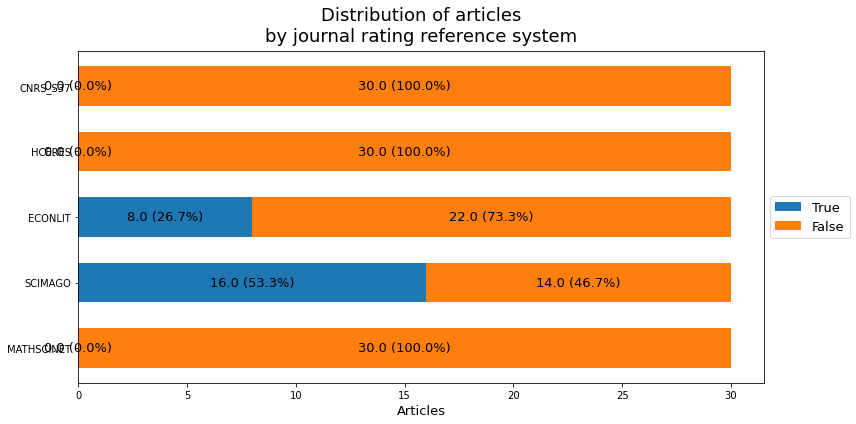

[2023-02-22 20:41:56][INFO ][hceres_ranking_plot#14] Create ranking plot "Distribution of articles
for the HCERES Vague B 2021 rating reference system" for HCERES (params={})
[2023-02-22 20:41:56][INFO ][csv#35] Export to CSV file: ./exports/rankings_all_hceres.csv (params: {'index': False}) (number of rows: 0)
[2023-02-22 20:41:56][INFO ][hceres_ranking_plot#35] Saved figure at "./exports/rankings_all_hceres.png"


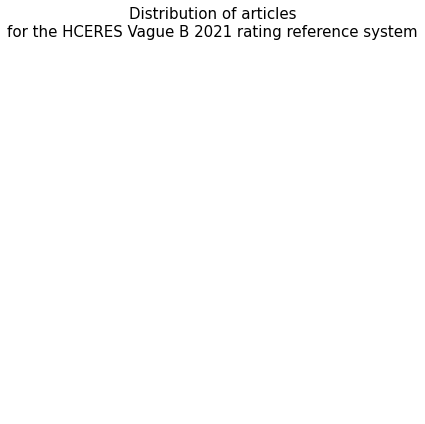

[2023-02-22 20:41:56][INFO ][cnrs_s37_ranking_plot#14] Create ranking plot "CNRS S37 articles ranking" for CNRS (params={})
[2023-02-22 20:41:56][INFO ][csv#35] Export to CSV file: ./exports/rankings_all_rankings_all_cnrs_s37.csv (params: {'index': False}) (number of rows: 0)
[2023-02-22 20:41:56][INFO ][pie#127] Export pie graph to PNG file: ./exports/rankings_all_cnrs_s37_articles_ranking.png


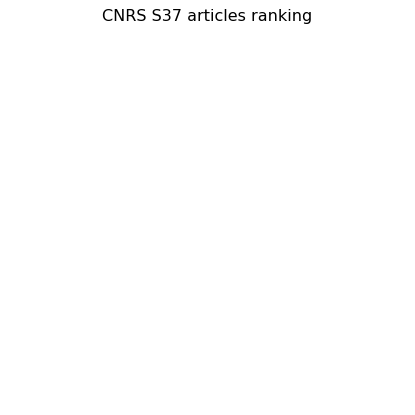

[2023-02-22 20:41:56][INFO ][cross_referentials_plot#27] Saved figure at "./exports/rankings_all_distribution_of_articles_in_journal_classification_referentials.png"


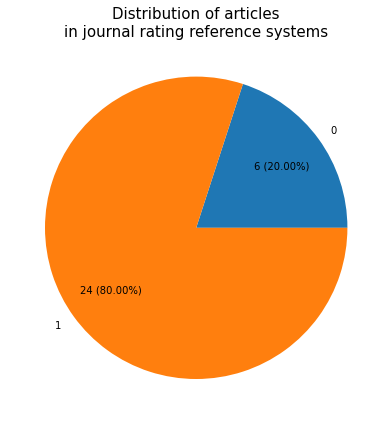

[2023-02-22 20:41:56][INFO ][scimago_hceres_matrix#8] Create Scimago / HCERES matrix
[2023-02-22 20:41:56][INFO ][scimago_hceres_matrix#13] Saved Excel at "./exports/rankings_all_hceres_scimago_matrix.xlsx"
[2023-02-22 20:41:56][INFO ][scimago_hceres_matrix#17] Saved Excel at "./exports/rankings_all_hceres_scimago_matrix_2.xlsx"
[2023-02-22 20:41:56][INFO ][scimago_rankings#8] Process scimago rankings (filename_prefix=rankings_all, titles={'Scimago JCR: categories': 'Distribution of articles by category\nfor the Scimago JCR rating reference system', 'Scimago JCR: quartiles': 'Distribution of articles by quartiles\nfor the Scimago JCR rating reference system'})
[2023-02-22 20:41:56][INFO ][create_scimajo_df#19] Saved CSV at "./exports/rankings_all_scimago.csv"
[2023-02-22 20:41:56][INFO ][create_scimajo_df#31] Saved CSV at "./exports/rankings_all_scimago_filtered_0.csv
[2023-02-22 20:41:57][INFO ][scimago_ranking_plot#38] Saved figure at "./exports/rankings_all_scimago_categories_0.png"

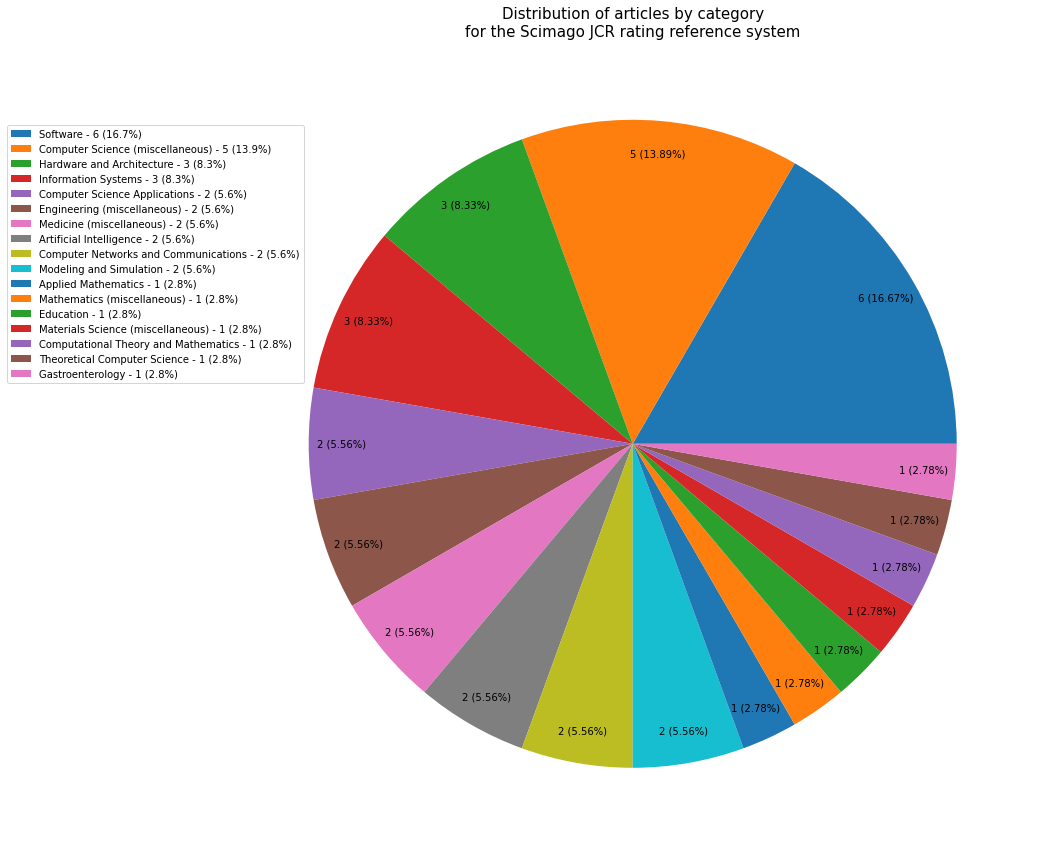

[2023-02-22 20:41:57][INFO ][scimago_ranking_plot#64] Saved figure at "./exports/rankings_all_scimago_sjr_q_score_0.png"


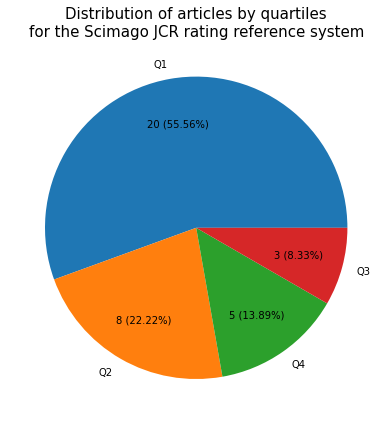

,uri_s,journalTitle_s,journalIssn_s,URL,ECONLIT,MATHSCINET,SCIMAGO_CATEGORIES,SJR_BEST_QUARTILE,SCIMAGO,HCERES_CONRS_RANK,HCERES_FNEGE_RANK,HCERES_RANK,HCERES,CNRS_S37_DOMAINE,CNRS_S37_CAT,CNRS_S37,NUMBER_OF_REFERENTIALS
0,https://hal.science/hal-02301045,International Journal of Engineering and Advan...,NaN,NaN,True,False,NaN,NaN,False,NaN,NaN,NaN,False,NaN,NaN,False,1
1,https://hal.science/hal-03566030,IoT Protocols and Applications for Improving I...,NaN,NaN,True,False,NaN,NaN,False,NaN,NaN,NaN,False,NaN,NaN,False,1
2,https://hal.science/hal-03451232,J. Wirel. Mob. Networks Ubiquitous Comput. Dep...,NaN,NaN,True,False,NaN,NaN,False,NaN,NaN,NaN,False,NaN,NaN,False,1
3,https://hal.science/hal-03520909,Blockchain: Research and Applications,NaN,NaN,True,False,NaN,NaN,False,NaN,NaN,NaN,False,NaN,NaN,False,1
4,https://hal.univ-lorraine.fr/hal-01722928,Corpus Pragmatics,2509-9507,NaN,False,False,NaN,NaN,False,NaN,NaN,NaN,False,NaN,NaN,False,0
5,https://hal-paris1.archives-ouvertes.fr/hal-01...,Artificial Intelligence in Medicine,0933-3657,NaN,False,False,Artificial Intelligence (Q1); Medicine (miscel...,Q1,True,NaN,NaN,NaN,False,NaN,NaN,False,1
6,https://hal.science/hal-03526302,INSIGHT - International Council on Systems Eng...,2156-4868,NaN,False,False,NaN,NaN,False,NaN,NaN,NaN,False,NaN,NaN,False,0
7,https://hal.science/hal-01843035,EAI Endorsed Transactions on Smart Cities,NaN,NaN,True,False,NaN,NaN,False,NaN,NaN,NaN,False,NaN,NaN,False,1
8,https://hal-paris1.archives-ouvertes.fr/hal-03...,Software and Systems Modeling,1619-1366,NaN,False,False,Modeling and Simulation (Q1); Software (Q2),Q1,True,NaN,NaN,NaN,False,NaN,NaN,False,1
9,https://hal-paris1.archives-ouvertes.fr/hal-03...,Complex Systems Informatics and Modeling Quart...,2255-9922,NaN,False,False,NaN,NaN,False,NaN,NaN,NaN,False,NaN,NaN,False,0


In [63]:
ranking_df = rankings(
    dataframe = df_art,
    filename_prefix = 'rankings_all',
    titles = {
        'Articles ranking': 'Distribution of articles\nby journal rating reference system',
        'HCERES articles ranking': 'Distribution of articles\nfor the HCERES Vague B 2021 rating reference system',
        'Distribution of articles': 'Distribution of articles\nin journal rating reference systems',
    }
)
scimago_hceres_matrix(dataframe = ranking_df, filename_prefix = 'rankings_all')
scimago_rankings(
    dataframe = ranking_df,
    filename_prefix = 'rankings_all',
    quantile = 0,
    titles = {
        'Scimago JCR: categories': 'Distribution of articles by category\nfor the Scimago JCR rating reference system',
        'Scimago JCR: quartiles':  'Distribution of articles by quartiles\nfor the Scimago JCR rating reference system',
    }
)
ranking_df

### Without HCERES & ECONLIT (CRI)

[2023-02-22 20:41:57][INFO ][rankings#7] Process ranking (filename_prefix=rankings_cri, titles={'Articles ranking': 'Distribution of articles\nby journal rating reference system', 'Distribution of articles': 'Distribution of articles\nin journal rating reference systems'})
[2023-02-22 20:41:57][INFO ][create_ranking_journals_df#6] Create ranking dataframe including: ['MATHSCINET', 'SCIMAGO'] (excludes=['HCERES', 'ECONLIT', 'CNRS_S37'])
[2023-02-22 20:41:57][INFO ][csv#35] Export to CSV file: ./exports/rankings_cri.csv (params: {'index': False}) (number of rows: 30)
[2023-02-22 20:41:57][INFO ][csv#35] Export to CSV file: ./exports/rankings_cri_filtered.csv (params: {'index': False}) (number of rows: 30)
[2023-02-22 20:41:57][INFO ][csv#35] Export to CSV file: ./exports/rankings_cri_count.csv (params: {'index': False}) (number of rows: 2)
[2023-02-22 20:41:57][INFO ][journals_ranking_plot#45] Saved figure at "./exports/rankings_cri_general.png"


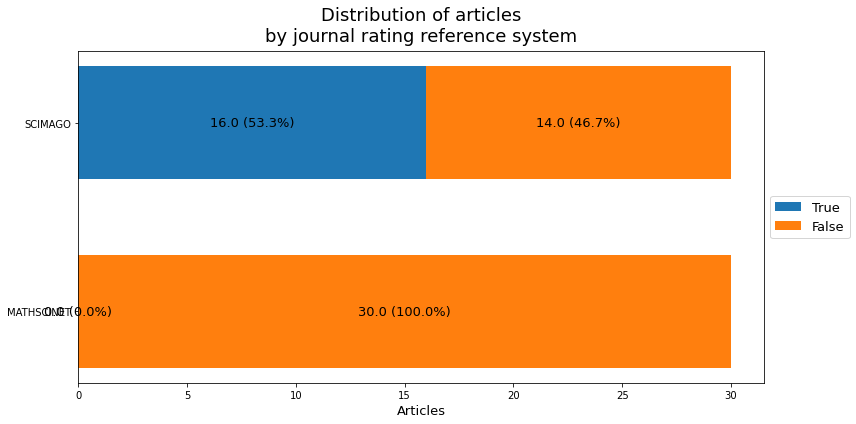

[2023-02-22 20:41:57][WARNING][hceres_ranking_plot#6] Skip plotting HCERES as "HCERES_RANK" is not a column of the DataFrame
[2023-02-22 20:41:57][WARNING][cnrs_s37_ranking_plot#6] Skip plotting CNRS_S37 as "CNRS_S37_CAT" is not a column of the DataFrame
[2023-02-22 20:41:57][INFO ][cross_referentials_plot#27] Saved figure at "./exports/rankings_cri_distribution_of_articles_in_journal_classification_referentials.png"


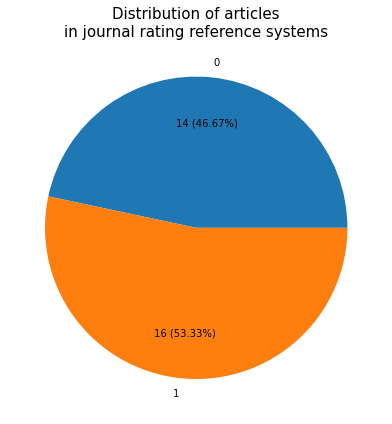

[2023-02-22 20:41:57][INFO ][scimago_rankings#8] Process scimago rankings (filename_prefix=rankings_cri, titles={'Scimago JCR: categories': 'Distribution of articles by category\nfor the Scimago JCR rating reference system', 'Scimago JCR: quartiles': 'Distribution of articles by quartiles\nfor the Scimago JCR rating reference system'})
[2023-02-22 20:41:57][INFO ][create_scimajo_df#19] Saved CSV at "./exports/rankings_cri_scimago.csv"
[2023-02-22 20:41:57][INFO ][create_scimajo_df#31] Saved CSV at "./exports/rankings_cri_scimago_filtered_0.csv
[2023-02-22 20:41:57][INFO ][scimago_ranking_plot#38] Saved figure at "./exports/rankings_cri_scimago_categories_0.png"


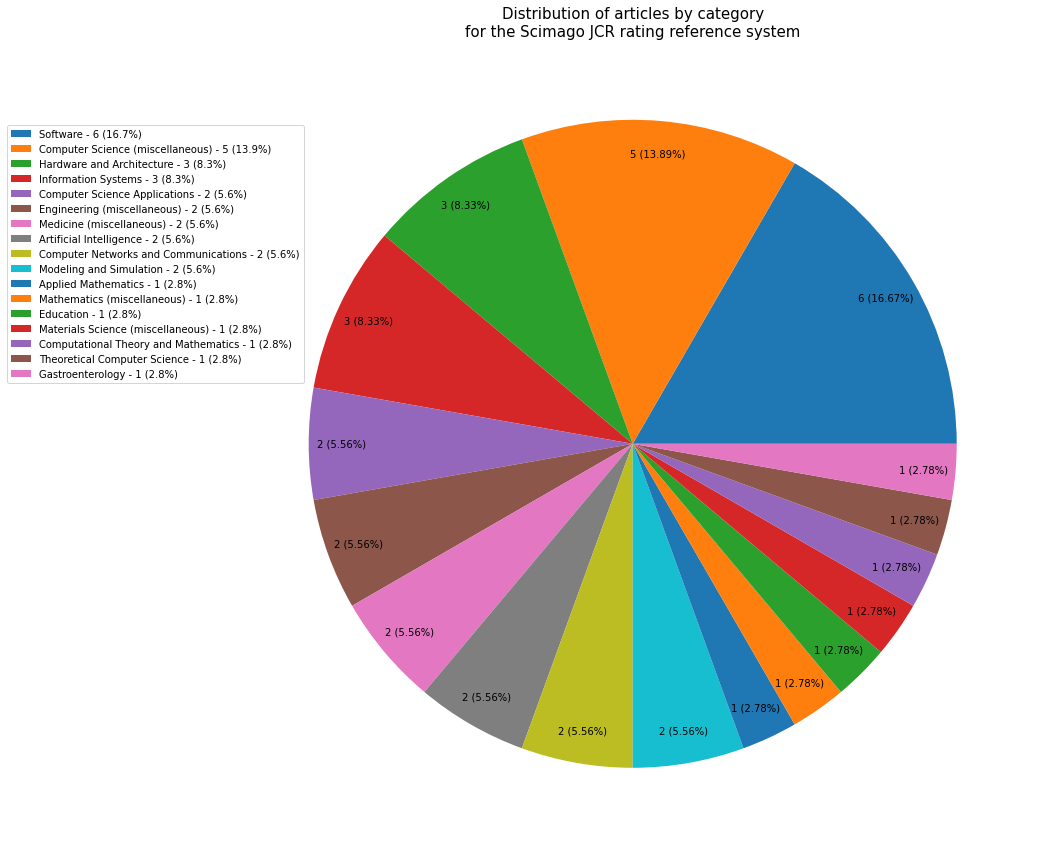

[2023-02-22 20:41:58][INFO ][scimago_ranking_plot#64] Saved figure at "./exports/rankings_cri_scimago_sjr_q_score_0.png"


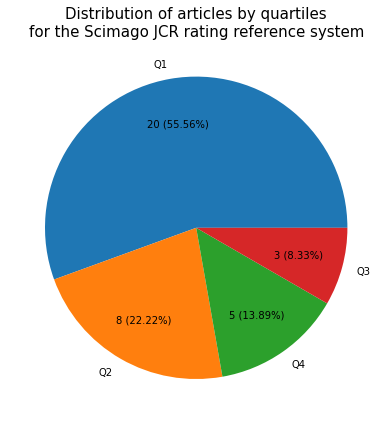

,uri_s,journalTitle_s,journalIssn_s,MATHSCINET,SCIMAGO_CATEGORIES,SJR_BEST_QUARTILE,SCIMAGO,NUMBER_OF_REFERENTIALS
0,https://hal.science/hal-02301045,International Journal of Engineering and Advan...,NaN,False,NaN,NaN,False,0
1,https://hal.science/hal-03566030,IoT Protocols and Applications for Improving I...,NaN,False,NaN,NaN,False,0
2,https://hal.science/hal-03451232,J. Wirel. Mob. Networks Ubiquitous Comput. Dep...,NaN,False,NaN,NaN,False,0
3,https://hal.science/hal-03520909,Blockchain: Research and Applications,NaN,False,NaN,NaN,False,0
4,https://hal.univ-lorraine.fr/hal-01722928,Corpus Pragmatics,2509-9507,False,NaN,NaN,False,0
5,https://hal-paris1.archives-ouvertes.fr/hal-01...,Artificial Intelligence in Medicine,0933-3657,False,Artificial Intelligence (Q1); Medicine (miscel...,Q1,True,1
6,https://hal.science/hal-03526302,INSIGHT - International Council on Systems Eng...,2156-4868,False,NaN,NaN,False,0
7,https://hal.science/hal-01843035,EAI Endorsed Transactions on Smart Cities,NaN,False,NaN,NaN,False,0
8,https://hal-paris1.archives-ouvertes.fr/hal-03...,Software and Systems Modeling,1619-1366,False,Modeling and Simulation (Q1); Software (Q2),Q1,True,1
9,https://hal-paris1.archives-ouvertes.fr/hal-03...,Complex Systems Informatics and Modeling Quart...,2255-9922,False,NaN,NaN,False,0


In [64]:
ranking_df = rankings(
    dataframe = df_art,
    filename_prefix = 'rankings_cri',
    excludes = ['HCERES', 'ECONLIT', 'CNRS_S37'],
    titles = {
        'Articles ranking': 'Distribution of articles\nby journal rating reference system',
        'Distribution of articles': 'Distribution of articles\nin journal rating reference systems',
    }
)
scimago_rankings(
    dataframe = ranking_df,
    filename_prefix = 'rankings_cri',
    quantile = 0,
    titles = {
        'Scimago JCR: categories': 'Distribution of articles by category\nfor the Scimago JCR rating reference system',
        'Scimago JCR: quartiles':  'Distribution of articles by quartiles\nfor the Scimago JCR rating reference system',
    }
)
ranking_df

### Without MATHSCINET (PHARE)

[2023-02-22 20:41:58][INFO ][rankings#7] Process ranking (filename_prefix=rankings_phare, titles={'Articles ranking': 'Distribution of articles\nby journal rating reference system', 'HCERES articles ranking': 'Distribution of articles\nfor the HCERES Vague C 2021 rating reference system', 'Distribution of articles': 'Distribution of articles\nin journal rating reference systems'})
[2023-02-22 20:41:58][INFO ][create_ranking_journals_df#6] Create ranking dataframe including: ['ECONLIT', 'SCIMAGO', 'HCERES', 'CNRS_S37'] (excludes=['MATHSCINET'])
[2023-02-22 20:41:58][INFO ][csv#35] Export to CSV file: ./exports/rankings_phare.csv (params: {'index': False}) (number of rows: 30)
[2023-02-22 20:41:58][INFO ][csv#35] Export to CSV file: ./exports/rankings_phare_filtered.csv (params: {'index': False}) (number of rows: 30)
[2023-02-22 20:41:58][INFO ][csv#35] Export to CSV file: ./exports/rankings_phare_count.csv (params: {'index': False}) (number of rows: 4)
[2023-02-22 20:41:58][INFO ][journ

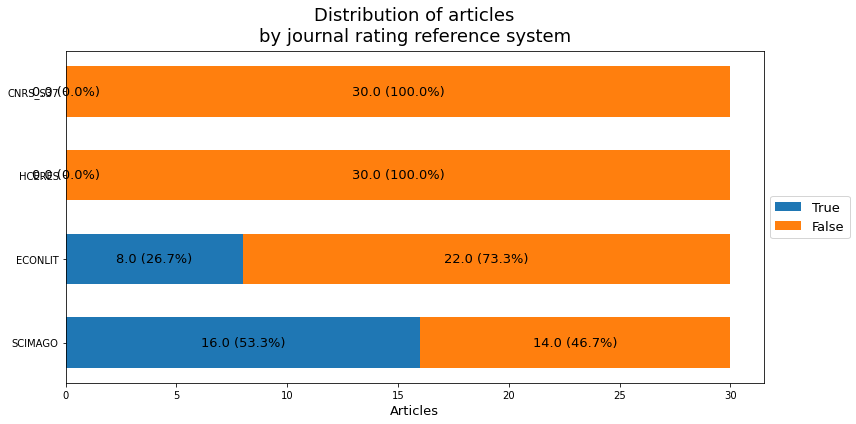

[2023-02-22 20:41:58][INFO ][hceres_ranking_plot#14] Create ranking plot "Distribution of articles
for the HCERES Vague C 2021 rating reference system" for HCERES (params={})
[2023-02-22 20:41:58][INFO ][csv#35] Export to CSV file: ./exports/rankings_phare_hceres.csv (params: {'index': False}) (number of rows: 0)
[2023-02-22 20:41:58][INFO ][hceres_ranking_plot#35] Saved figure at "./exports/rankings_phare_hceres.png"


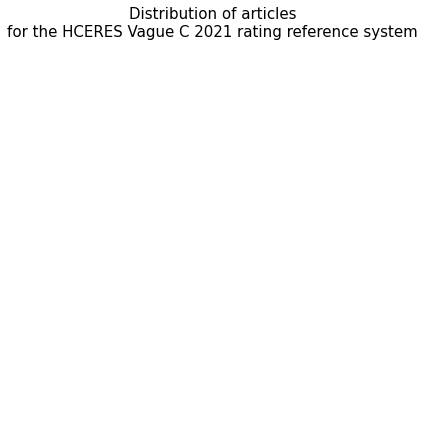

[2023-02-22 20:41:58][INFO ][cnrs_s37_ranking_plot#14] Create ranking plot "CNRS S37 articles ranking" for CNRS (params={})
[2023-02-22 20:41:58][INFO ][csv#35] Export to CSV file: ./exports/rankings_phare_rankings_phare_cnrs_s37.csv (params: {'index': False}) (number of rows: 0)
[2023-02-22 20:41:58][INFO ][pie#127] Export pie graph to PNG file: ./exports/rankings_phare_cnrs_s37_articles_ranking.png


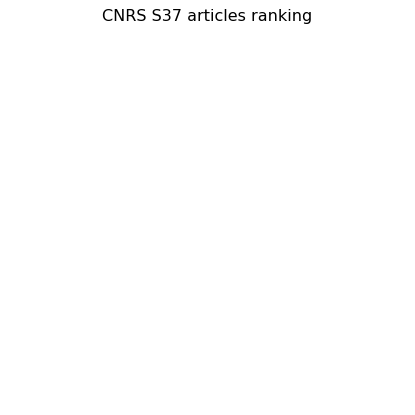

[2023-02-22 20:41:58][INFO ][cross_referentials_plot#27] Saved figure at "./exports/rankings_phare_distribution_of_articles_in_journal_classification_referentials.png"


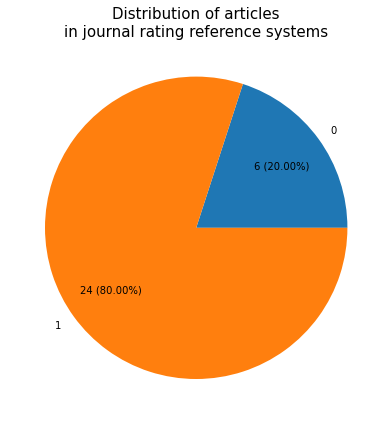

[2023-02-22 20:41:58][INFO ][scimago_hceres_matrix#8] Create Scimago / HCERES matrix
[2023-02-22 20:41:58][INFO ][scimago_hceres_matrix#13] Saved Excel at "./exports/rankings_phare_hceres_scimago_matrix.xlsx"
[2023-02-22 20:41:58][INFO ][scimago_hceres_matrix#17] Saved Excel at "./exports/rankings_phare_hceres_scimago_matrix_2.xlsx"
[2023-02-22 20:41:58][INFO ][scimago_rankings#8] Process scimago rankings (filename_prefix=rankings_phare, titles={'Scimago JCR: categories': 'Distribution of articles by category\nfor the Scimago JCR rating reference system', 'Scimago JCR: quartiles': 'Distribution of articles by quartiles\nfor the Scimago JCR rating reference system'})
[2023-02-22 20:41:58][INFO ][create_scimajo_df#19] Saved CSV at "./exports/rankings_phare_scimago.csv"
[2023-02-22 20:41:58][INFO ][create_scimajo_df#31] Saved CSV at "./exports/rankings_phare_scimago_filtered_0.csv
[2023-02-22 20:41:58][INFO ][scimago_ranking_plot#38] Saved figure at "./exports/rankings_phare_scimago_categ

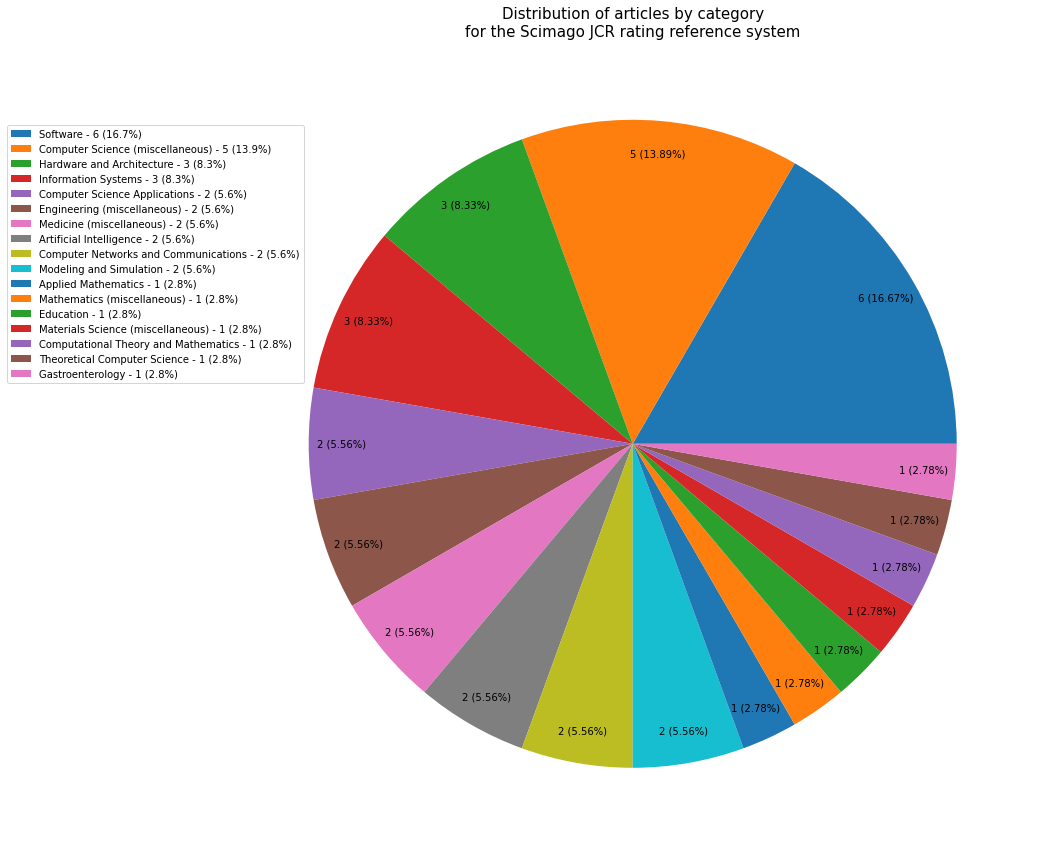

[2023-02-22 20:41:59][INFO ][scimago_ranking_plot#64] Saved figure at "./exports/rankings_phare_scimago_sjr_q_score_0.png"


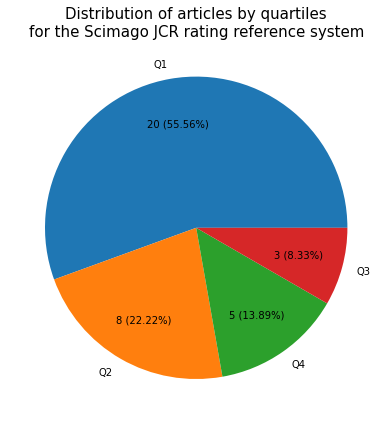

,uri_s,journalTitle_s,journalIssn_s,URL,ECONLIT,SCIMAGO_CATEGORIES,SJR_BEST_QUARTILE,SCIMAGO,HCERES_CONRS_RANK,HCERES_FNEGE_RANK,HCERES_RANK,HCERES,CNRS_S37_DOMAINE,CNRS_S37_CAT,CNRS_S37,NUMBER_OF_REFERENTIALS
0,https://hal.science/hal-02301045,International Journal of Engineering and Advan...,NaN,NaN,True,NaN,NaN,False,NaN,NaN,NaN,False,NaN,NaN,False,1
1,https://hal.science/hal-03566030,IoT Protocols and Applications for Improving I...,NaN,NaN,True,NaN,NaN,False,NaN,NaN,NaN,False,NaN,NaN,False,1
2,https://hal.science/hal-03451232,J. Wirel. Mob. Networks Ubiquitous Comput. Dep...,NaN,NaN,True,NaN,NaN,False,NaN,NaN,NaN,False,NaN,NaN,False,1
3,https://hal.science/hal-03520909,Blockchain: Research and Applications,NaN,NaN,True,NaN,NaN,False,NaN,NaN,NaN,False,NaN,NaN,False,1
4,https://hal.univ-lorraine.fr/hal-01722928,Corpus Pragmatics,2509-9507,NaN,False,NaN,NaN,False,NaN,NaN,NaN,False,NaN,NaN,False,0
5,https://hal-paris1.archives-ouvertes.fr/hal-01...,Artificial Intelligence in Medicine,0933-3657,NaN,False,Artificial Intelligence (Q1); Medicine (miscel...,Q1,True,NaN,NaN,NaN,False,NaN,NaN,False,1
6,https://hal.science/hal-03526302,INSIGHT - International Council on Systems Eng...,2156-4868,NaN,False,NaN,NaN,False,NaN,NaN,NaN,False,NaN,NaN,False,0
7,https://hal.science/hal-01843035,EAI Endorsed Transactions on Smart Cities,NaN,NaN,True,NaN,NaN,False,NaN,NaN,NaN,False,NaN,NaN,False,1
8,https://hal-paris1.archives-ouvertes.fr/hal-03...,Software and Systems Modeling,1619-1366,NaN,False,Modeling and Simulation (Q1); Software (Q2),Q1,True,NaN,NaN,NaN,False,NaN,NaN,False,1
9,https://hal-paris1.archives-ouvertes.fr/hal-03...,Complex Systems Informatics and Modeling Quart...,2255-9922,NaN,False,NaN,NaN,False,NaN,NaN,NaN,False,NaN,NaN,False,0


In [65]:
ranking_df = rankings(
    dataframe = df_art,
    filename_prefix = 'rankings_phare',
    excludes = ['MATHSCINET'],
    titles = {
        'Articles ranking': 'Distribution of articles\nby journal rating reference system',
        'HCERES articles ranking': 'Distribution of articles\nfor the HCERES Vague C 2021 rating reference system',
        'Distribution of articles': 'Distribution of articles\nin journal rating reference systems',
    }
)
scimago_hceres_matrix(dataframe = ranking_df, filename_prefix = 'rankings_phare')
scimago_rankings(
    filename_prefix = 'rankings_phare',
    dataframe = ranking_df,
    quantile = 0,
    titles = {
        'Scimago JCR: categories': 'Distribution of articles by category\nfor the Scimago JCR rating reference system',
        'Scimago JCR: quartiles':  'Distribution of articles by quartiles\nfor the Scimago JCR rating reference system',
    }
)
ranking_df

## Peer reviewing

[2023-02-22 20:41:59][INFO ][csv#35] Export to CSV file: ./exports/articles-peer-reviewing.csv (params: {'index': True}) (number of rows: 2)
[2023-02-22 20:41:59][INFO ][pie#127] Export pie graph to PNG file: ./exports/discribution_of_articles_with_peer_reviewing.png


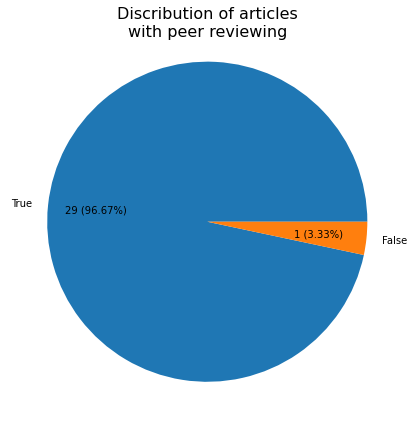

,peerReviewing_s,count
0,True,29
1,False,1


In [66]:
peer_reviewing = df_art[['uri_s', 'peerReviewing_s']].fillna(0).astype({'peerReviewing_s': 'int'})
peer_reviewing['peerReviewing_s'] = peer_reviewing.apply(func=lambda r: r['peerReviewing_s'] == 1, axis='columns')
DfOps(peer_reviewing) \
    .count(subset=['peerReviewing_s'], column='count') \
    .csv('articles-peer-reviewing.csv') \
    .pie(
        column='count',
        label_column='peerReviewing_s',
        title='Discribution of articles\nwith peer reviewing',
        plot_params=dict(figsize=(6,6), pctdistance=0.7),
        sort_params=dict(ascending=False)
    )